# Unit 4 Project
by: Dannar Mawardi

Tasked by a contracting firm to model solutions to predict salary and seniority of job ads based on available job post information

This project will involve collection of data through scraping, then using that data to answer the following questions:

Q1: What factors impact salary?

Q2: What features are best able to determine senior vs. junior positions?

![title](work.jpg)

# Executive Summary
In order to answer the questions, we need job data that will allow us to effectively solve the problem.

## Data Collection

We began by searching for three particular key word groups on Seek.com.au: Data Analyst, Data Scientist, and Business Analyst (as there were a lot of technical business analyst ads).  

We used a combination of Selenium, Requests and Scrapy's Selector, to automate the browser to search then scrape/extract job details from each search results page.  This included date of post, job summary, job type, hiring company, industry, job title, job url, Seek job ID, city and suburb. 
The salary and full job description was not available on the results page, and required a second session of scraping/extraction.  An iterator that went through the previously scraped information's job URLs was created to grab the missing information into a separate table. These were then merged based on job ID.

### Parsing
The salary information was extracted as a string, which means that it requires to be parsed. This was done in two stages. 

Firstly, we need to use regular expressions to extract the numbers from the text. This number will be categorised based on the surrounding text, such as 'per hour', 'per day', 'per annum'.  These were then converted to either a daily rate or salary rate by column.

Secondly, a method would iterate through these two columns to determine if there are any numbers that may have wrongfully included cents, or other formatting issues such as using 'k' for thousands.
This same method then places all the salary on equal footing by converting all non-per-annum rates to per-annum.

Once converted, all job data was combined into one job table.

## EDA
Once we had all of our data, we were able to engage in some quick exploratory analysis.  It was observed that a significant outlier was present within the salary column and removed from the model to improve accuracy. The outlier was not incorrectly scraped, however, it was an ad for a systems implementation manager that skewed the data greatly (salaray p.a: $1.4m+)

Using pivot tables and groups, we were able to get general observations of our data. 
* Job type groups showed us that the best paid are those with contract or temporary work, followed by full time, then part time. 
* Better than average paid jobs are in Albany & Great Southern and Bairnsdale& Gippsland, followed by Geraldton, Gascoyne & Midwest.
* By suburb, the most highest paid jobs are advertised in Brisbane, Northern suburbs, with mean rates close to $200k. 
* By industry, the highest paid professionals operate within the mining, resources, and energy industry with mean rates over $175k.  These are distantly followed by Admin/office support and science & technology respectively.

## Model Building
### Q1: What factors impact salary?
To begin with, let's see if using Natural Language Processing on the job description data will allow us to create an accurate model.  We also filter any stop words that are useless (Mostly contain numerical information). We instantiate both a CountVectorizer and TfidfVectorizer to compare the results of using both with Ridge regression.  Upon using both, it's obvious that there is an improvement when using TFidfVectorizer (achieves 14.9% score) over the other. Due to this, we proceed using this vectorizer. 
Improving the model can be attempted through the use of a stemmer to more easily categorize similar word prefixes. However, we found that this did not improve our model, resulting in a decreased score of 13.6%. Due to this, we do not proceed to use a stemmer in future models.
To further improve upon our model, we gridsearch optimal parameters. This assisted us in pushing the score from 14.9% to 19%.
Other models?
A decision tree and Elastic Net CV model was also tested. The decision tree performed awfully with a negative score, and the Elastic Net CV performed worse than Ridge at 14.2% (after gridsearch). 
Further improvements?
During our EDA, we saw that jobtype, industry and city play a role in salary levels.  We want to see if including these in our model, will increase performance. 
We broke down the features above into their dummy variables and combined it with the word matrix generated by the vectorizer. We also are able to include title text inclusions as dummies (ie. Whether job title contains Data, Python, Analyst, SQL). Once combined, we use this as our features for the model.
It turns out that an improvement was achieved by including the dummy variables in our model.  The score achieved was improved to 21.33%.

### Q2: What features are best able to determine senior vs. junior positions?
In order to generate our target variable (the variable we wish to predict), we must cycle through the job title information to add a binary value of 1 or 0 depending on whether a 'senior' job position was detected. The feature list will be created by repeating the process of dummy variable creation in the previous question. This allows us to use the same factors of industry, city, job type, words in title, to predict senior ad positions. 

Three models were used in this question: Random Forest classifier, Decision Tree classifier, and Ridge classifier. A consistent score above 80% was generated for all three models, however, upon closer inspection, it was found that each model had different coefficient waitings. 

Through the process of feature selection, a lot of the dummy variables were removed, leaving only:
* Melbourne location
* Full time positions
* Contract/Temp positions
* Industry: Information & Comm technology, CEO & Gen. mgmt, Hospitality/tourism, Mining, resources & energy
* Analyst in the title

Through only including these factors, and gridsearch, we are able to improve efficiency of our model and maintain our score at 83.48%. We have generated a leaner, yet just as effective model to predict senior ad positions.

# Webscraping
We first need to instantiate and prepare a webscraper to collect our data
We will use a combination of Python's Selenium, Requests, and Scrapy's Selector packages to achieve this

In [365]:
import urllib
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd
import requests
import json
import bs4
from bs4 import BeautifulSoup
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [94]:
# Point webdriver to the path of browser driver
driver = webdriver.Chrome(executable_path='/users/D/Desktop/Resources/chromedriver')

# Seek Search Terms
* Each cell below contains the search key words input and search submission.
* Run only one cell below dependent on the type of title searched and it will push you to the search results page

### Data Analyst search

In [ ]:
driver.get('https://www.seek.com.au/')

keywords = driver.find_element_by_xpath('//*[@id="SearchBar__Keywords"]')
keywords.send_keys('Data Analyst')

location = driver.find_element_by_xpath('//*[@id="SearchBar__Where"]')
location.send_keys('All Australia')

first_job = driver.find_element_by_xpath('//*[@id="SearchBar"]/button')
first_job.submit()

### Data Scientist search

In [ ]:
driver.get('https://www.seek.com.au/')

keywords = driver.find_element_by_xpath('//*[@id="SearchBar__Keywords"]')
keywords.send_keys('Data Scientist')

location = driver.find_element_by_xpath('//*[@id="SearchBar__Where"]')
location.send_keys('All Australia')

first_job = driver.find_element_by_xpath('//*[@id="SearchBar"]/button')
first_job.submit()

### Business Analyst search

In [ ]:
driver.get('https://www.seek.com.au/')

keywords = driver.find_element_by_xpath('//*[@id="SearchBar__Keywords"]')
keywords.send_keys('Business Analyst')

location = driver.find_element_by_xpath('//*[@id="SearchBar__Where"]')
location.send_keys('All Australia')

first_job = driver.find_element_by_xpath('//*[@id="SearchBar"]/button')
first_job.submit()

# Job Search Result Scrapes by page
* Created function ArticleScrape for scraping a page of search result listings (Scrapes the JSON file behind each article/job listing and reads them into a dictionary)

Details scraped:
* date of post
* job summary
* job type
* hiring company
* industry
* job title
* job url
* Seek job ID
* city 
* suburb

In [ ]:
# For Articles on page (usually 20 articles per page), extract details
def ArticleScrape(ArticleNum, HTML):

    # Extract json and convert to dictionary
    print('Extracting Art#: {}'.format(ArticleNum))
    try: 
        extract = Selector(text=HTML).xpath('//article['+str(ArticleNum)+']/script/text()').extract()
        jobDict = json.loads(extract[0])

        # Extract details from jobDict
        postDate = jobDict['datePosted']
        jobSummary = jobDict['description']
        jobType = jobDict['employmentType']
        compName = jobDict['hiringOrganization']['name']
        industry = jobDict['industry']
        jobTitle = jobDict['title']
        jobURL = jobDict['url']
        jobID = jobDict['url'][-8:]
        city = jobDict['jobLocation']['address']['addressRegion']
        
        
        # If suburb information is unable to be scraped, set as nan
        try:
            suburb = jobDict['jobLocation']['address']['addressLocality']

        except:
            suburb = np.nan

        # Turn the parsed data into a dictionary for dataframe append
        job_forApp = {
            'Job_ID': jobID, 
            'Job_URL': jobURL, 
            'Title': jobTitle, 
            'Type': jobType, 
            'City': city, 
            'Suburb': suburb, 
            'Industry':industry,
            'Hiring_Ent': compName, 
            'Summary': jobSummary, 
            'Post_Date': postDate
        }
    except:
        # If error encountered, assume end of search reached
        print('Last Article of search extracted')
    return job_forApp
    

In [ ]:
# Initialize empty dataframe
jobs = pd.DataFrame(columns=['Job_ID', 'Job_URL', 'Title', 'Type', 'City', 'Suburb', 'Industry', 'Hiring_Ent', 'Summary',
                      'Post_Date'])

# Job Search Scraper
* Iterates through search result pages and uses ArticleScrape function (above) to take details from JSON file within each article

In [ ]:
# Initialize Error count to 0
nextError = 0
PageCount = 0
# Scrape and go to next page so long as there is a next button to click
while nextError == 0:
    PageCount += 1
    response = requests.get(driver.current_url)
    HTML = response.text
    
    print('Page: {}'.format(PageCount))
    # Append to jobs the 
    for article in range(1,21):
        print(article)
        job_append = ArticleScrape(article, HTML)
        print('To be appended\n{}'.format(job_append))
        jobs = jobs.append(job_append, ignore_index=True)
    
    

    # Next Button
    try: 
        Next_Btn = driver.find_element_by_class_name('_1XIONbW')
        print('Next Button found, clicking.')
        Next_Btn.click()
    except:
        print('We have reached the end of the search')
        nextError +=1

# Export Scraped jobs
To save our progress, we will export our current scraped data into a CSV file.

## First CHECKPOINT

In [ ]:
# Export job scrape to csv
jobs = jobs.drop_duplicates(inplace=True)
jobs.to_csv('./datasets/job_scrape.csv', index=False, encoding='utf-8')

# Subset table (jobLinks) for additional scraping
* Creates table with job ID and URL with additional two NaN columns to fill from scrape

In [284]:
#Read saved CSV into dataframe: jobs
jobs = pd.read_csv('./datasets/job_scrape.csv')

# Subset job urls and ID to scrape additional job description
jobLinks = jobs.iloc[:,:2]
jobLinks.reset_index(drop=True, inplace=True)

# Create new NaN (empty) columns to scrape salary and description information
jobLinks['job_Desc'] = np.nan
jobLinks['job_Salary'] = np.nan
jobLinks.head()

,Job_ID,Job_URL,job_Desc,job_Salary
0,34376436,https://www.seek.com.au/job/34376436,NaN,NaN
1,34376394,https://www.seek.com.au/job/34376394,NaN,NaN
2,34376246,https://www.seek.com.au/job/34376246,NaN,NaN
3,34375173,https://www.seek.com.au/job/34375173,NaN,NaN
4,34373096,https://www.seek.com.au/job/34373096,NaN,NaN


## Create function for scraping the job description text given the URL
* The function below goes to a job page and extracts salary and text description information when given a URL

In [73]:
def jobDescScraper(jobUrl):
    """Goes to jobUrl parameter to fetch job description text. 
    Cleans, then returns as string
    
    """
    # Job Page Description scraper
    driver.get(jobUrl)
    time.sleep(2)
    Description = driver.find_element_by_class_name('_17ZYgCC')
    raw_html = Description.get_attribute('innerHTML')

    # Create regex compiler to find items in between tags
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner, '', raw_html)
    return cleantext

# Job Page Extractor
* The below code uses the jobDescScraper function (above) to grab salary and job description information using job URL

In [132]:
# Instantiate error counter
error = 0
# Iterates through Job_URL series of jobLinks DF
for i, val in enumerate(jobLinks['Job_URL'][1637:]):
    itemIndex = jobLinks['Job_URL'][jobLinks['Job_URL'] == val].index
    print('i: {} | val: {} | itemIndex: {} '.format(i,val, itemIndex))

    try: 
        jobText = jobDescScraper(val)
        # Edit corresponding cell in job_Desc series to add description text information
        jobLinks['job_Desc'][itemIndex] = jobText
        print('Appended: {} to index: {}'.format(jobText[:12], itemIndex))
        
        # Send url from Selenium to Requests to be converted to HTML text
        response = requests.get(driver.current_url)
        HTML = response.text
        try:
            # Use Selector to select text using xpath
            extract = Selector(text=HTML).xpath('''//*[@id="app"]/div/div[2]/div[1]/div/div/div[2]/div/div[2]/aside/span/
            div[1]/div/section/dl/div[1]/dd/span/span/text()''').extract()

            # Edit corresponding cell in job_Salary to add salary information
            jobLinks['job_Salary'][itemIndex]= extract
        except:
            print('Salary was not found')
        error = 0
        
        # Halt code processing for 5 seconds, to ensure requests to server don't reach threshold
        time.sleep(5)
        
        # Delete cookies to further improve scraping by lowering chance of detection
        driver.delete_all_cookies()
        
    except:
        # If error encountered, print notification
        print('Couldnt grab text')
        
        error += 1
        # If error has occurred more than twice in a row, break from loop
        if error == 2:
            print('Error met twice, breaking from loop')
            break;

i: 0 | val: https://www.seek.com.au/job/34194627 | itemIndex: Int64Index([1637], dtype='int64') 
Couldnt grab text
i: 1 | val: https://www.seek.com.au/job/34194224 | itemIndex: Int64Index([1638], dtype='int64') 
Couldnt grab text
i: 2 | val: https://www.seek.com.au/job/34193200 | itemIndex: Int64Index([1639], dtype='int64') 
Couldnt grab text
i: 3 | val: https://www.seek.com.au/job/34193181 | itemIndex: Int64Index([1640], dtype='int64') 
Couldnt grab text
i: 4 | val: https://www.seek.com.au/job/34192801 | itemIndex: Int64Index([1641], dtype='int64') 
Couldnt grab text
i: 5 | val: https://www.seek.com.au/job/34192235 | itemIndex: Int64Index([1642], dtype='int64') 
Couldnt grab text
i: 6 | val: https://www.seek.com.au/job/34193301 | itemIndex: Int64Index([1643], dtype='int64') 
Couldnt grab text
i: 7 | val: https://www.seek.com.au/job/34234957 | itemIndex: Int64Index([1644], dtype='int64') 


/Users/d/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Appended: Opportunity: to index: Int64Index([1644], dtype='int64')


/Users/d/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


i: 8 | val: https://www.seek.com.au/job/34195522 | itemIndex: Int64Index([1645], dtype='int64') 
Couldnt grab text
i: 9 | val: https://www.seek.com.au/job/34192045 | itemIndex: Int64Index([1646], dtype='int64') 
Couldnt grab text
i: 10 | val: https://www.seek.com.au/job/34195426 | itemIndex: Int64Index([1647], dtype='int64') 
Couldnt grab text
i: 11 | val: https://www.seek.com.au/job/34189235 | itemIndex: Int64Index([1648], dtype='int64') 
Couldnt grab text
i: 12 | val: https://www.seek.com.au/job/34194551 | itemIndex: Int64Index([1649], dtype='int64') 
Couldnt grab text
i: 13 | val: https://www.seek.com.au/job/34194187 | itemIndex: Int64Index([1650], dtype='int64') 
Couldnt grab text
i: 14 | val: https://www.seek.com.au/job/34231835 | itemIndex: Int64Index([1651], dtype='int64') 
Appended: Integria Hea to index: Int64Index([1651], dtype='int64')
Salary was not found
i: 15 | val: https://www.seek.com.au/job/34192927 | itemIndex: Int64Index([1652], dtype='int64') 
Couldnt grab text
i: 1

Appended: Business Pro to index: Int64Index([1698], dtype='int64')
i: 62 | val: https://www.seek.com.au/job/34415465 | itemIndex: Int64Index([1699], dtype='int64') 
Appended: About Contem to index: Int64Index([1699], dtype='int64')
Salary was not found
i: 63 | val: https://www.seek.com.au/job/34415466 | itemIndex: Int64Index([1700], dtype='int64') 
Appended: About Contem to index: Int64Index([1700], dtype='int64')
Salary was not found
i: 64 | val: https://www.seek.com.au/job/34414013 | itemIndex: Int64Index([1701], dtype='int64') 
Appended: You will hav to index: Int64Index([1701], dtype='int64')
Salary was not found
i: 65 | val: https://www.seek.com.au/job/34218978 | itemIndex: Int64Index([1702], dtype='int64') 
Appended: Drakes Super to index: Int64Index([1702], dtype='int64')
Salary was not found
i: 66 | val: https://www.seek.com.au/job/34413666 | itemIndex: Int64Index([1703], dtype='int64') 
Appended: We are worki to index: Int64Index([1703], dtype='int64')
i: 67 | val: https://www

Salary was not found
i: 109 | val: https://www.seek.com.au/job/34397217 | itemIndex: Int64Index([1746], dtype='int64') 
Appended: Skills &amp; to index: Int64Index([1746], dtype='int64')
Salary was not found
i: 110 | val: https://www.seek.com.au/job/34396629 | itemIndex: Int64Index([1747], dtype='int64') 
Appended: I have been  to index: Int64Index([1747], dtype='int64')
i: 111 | val: https://www.seek.com.au/job/34210733 | itemIndex: Int64Index([1748], dtype='int64') 
Appended: The Role  We to index: Int64Index([1748], dtype='int64')
i: 112 | val: https://www.seek.com.au/job/34213465 | itemIndex: Int64Index([1749], dtype='int64') 
Appended: Downer's Roa to index: Int64Index([1749], dtype='int64')
Salary was not found
i: 113 | val: https://www.seek.com.au/job/34213464 | itemIndex: Int64Index([1750], dtype='int64') 
Appended: Downer's Roa to index: Int64Index([1750], dtype='int64')
Salary was not found
i: 114 | val: https://www.seek.com.au/job/34203189 | itemIndex: Int64Index([1751], dty

Appended: We are build to index: Int64Index([1792], dtype='int64')
i: 156 | val: https://www.seek.com.au/job/34337048 | itemIndex: Int64Index([1793], dtype='int64') 
Appended: We are build to index: Int64Index([1793], dtype='int64')
i: 157 | val: https://www.seek.com.au/job/34302936 | itemIndex: Int64Index([1794], dtype='int64') 
Appended: Security Eng to index: Int64Index([1794], dtype='int64')
Salary was not found
i: 158 | val: https://www.seek.com.au/job/34364953 | itemIndex: Int64Index([1795], dtype='int64') 
Couldnt grab text
i: 159 | val: https://www.seek.com.au/job/34364638 | itemIndex: Int64Index([1796], dtype='int64') 
Appended: Our client U to index: Int64Index([1796], dtype='int64')
Salary was not found
i: 160 | val: https://www.seek.com.au/job/34364636 | itemIndex: Int64Index([1797], dtype='int64') 
Appended: Our client U to index: Int64Index([1797], dtype='int64')
Salary was not found
i: 161 | val: https://www.seek.com.au/job/34364635 | itemIndex: Int64Index([1798], dtype=

Appended: Macquarie is to index: Int64Index([1840], dtype='int64')
i: 204 | val: https://www.seek.com.au/job/34418507 | itemIndex: Int64Index([1841], dtype='int64') 
Appended: ABOUT THOUGH to index: Int64Index([1841], dtype='int64')
Salary was not found
i: 205 | val: https://www.seek.com.au/job/34342511 | itemIndex: Int64Index([1842], dtype='int64') 
Appended: Our client,  to index: Int64Index([1842], dtype='int64')
Salary was not found
i: 206 | val: https://www.seek.com.au/job/34416236 | itemIndex: Int64Index([1843], dtype='int64') 
Appended: November Sta to index: Int64Index([1843], dtype='int64')
i: 207 | val: https://www.seek.com.au/job/34416181 | itemIndex: Int64Index([1844], dtype='int64') 
Appended: About VIIEWV to index: Int64Index([1844], dtype='int64')
Salary was not found
i: 208 | val: https://www.seek.com.au/job/34416088 | itemIndex: Int64Index([1845], dtype='int64') 
Appended: Civica is lo to index: Int64Index([1845], dtype='int64')
Salary was not found
i: 209 | val: https

i: 249 | val: https://www.seek.com.au/job/34408141 | itemIndex: Int64Index([1886], dtype='int64') 
Appended: Now I would  to index: Int64Index([1886], dtype='int64')
i: 250 | val: https://www.seek.com.au/job/34323621 | itemIndex: Int64Index([1887], dtype='int64') 
Appended: Drive commer to index: Int64Index([1887], dtype='int64')
Salary was not found
i: 251 | val: https://www.seek.com.au/job/34407339 | itemIndex: Int64Index([1888], dtype='int64') 
Appended: about Tic:To to index: Int64Index([1888], dtype='int64')
Salary was not found
i: 252 | val: https://www.seek.com.au/job/34323578 | itemIndex: Int64Index([1889], dtype='int64') 
Appended: MS Dynamics  to index: Int64Index([1889], dtype='int64')
i: 253 | val: https://www.seek.com.au/job/34407269 | itemIndex: Int64Index([1890], dtype='int64') 
Appended: Green Light  to index: Int64Index([1890], dtype='int64')
Salary was not found
i: 254 | val: https://www.seek.com.au/job/34407032 | itemIndex: Int64Index([1891], dtype='int64') 
Appended

Appended: Do you belie to index: Int64Index([1933], dtype='int64')
Salary was not found
i: 297 | val: https://www.seek.com.au/job/34387870 | itemIndex: Int64Index([1934], dtype='int64') 
Appended: My client's  to index: Int64Index([1934], dtype='int64')
Salary was not found
i: 298 | val: https://www.seek.com.au/job/34387505 | itemIndex: Int64Index([1935], dtype='int64') 
Appended: The companyM to index: Int64Index([1935], dtype='int64')
i: 299 | val: https://www.seek.com.au/job/34301833 | itemIndex: Int64Index([1936], dtype='int64') 
Appended: Our customer to index: Int64Index([1936], dtype='int64')
i: 300 | val: https://www.seek.com.au/job/34384009 | itemIndex: Int64Index([1937], dtype='int64') 
Appended: Who's it wit to index: Int64Index([1937], dtype='int64')
Salary was not found
i: 301 | val: https://www.seek.com.au/job/34382470 | itemIndex: Int64Index([1938], dtype='int64') 
Appended: As a Data Mo to index: Int64Index([1938], dtype='int64')
Salary was not found
i: 302 | val: https

i: 345 | val: https://www.seek.com.au/job/34357196 | itemIndex: Int64Index([1982], dtype='int64') 
Appended: At Foxtel, o to index: Int64Index([1982], dtype='int64')
Salary was not found
i: 346 | val: https://www.seek.com.au/job/34362469 | itemIndex: Int64Index([1983], dtype='int64') 
Appended: Calling all  to index: Int64Index([1983], dtype='int64')
i: 347 | val: https://www.seek.com.au/job/34356501 | itemIndex: Int64Index([1984], dtype='int64') 
Appended: Senior Sales to index: Int64Index([1984], dtype='int64')
i: 348 | val: https://www.seek.com.au/job/34305153 | itemIndex: Int64Index([1985], dtype='int64') 
Appended: The CompanyO to index: Int64Index([1985], dtype='int64')
Salary was not found
i: 349 | val: https://www.seek.com.au/job/34302074 | itemIndex: Int64Index([1986], dtype='int64') 
Appended: We are now r to index: Int64Index([1986], dtype='int64')
Salary was not found
i: 350 | val: https://www.seek.com.au/job/34353763 | itemIndex: Int64Index([1987], dtype='int64') 
Appended

i: 391 | val: https://www.seek.com.au/job/34276612 | itemIndex: Int64Index([2028], dtype='int64') 
Appended: 2XM Technolo to index: Int64Index([2028], dtype='int64')
Salary was not found
i: 392 | val: https://www.seek.com.au/job/34331697 | itemIndex: Int64Index([2029], dtype='int64') 
Appended: Excellent op to index: Int64Index([2029], dtype='int64')
Salary was not found
i: 393 | val: https://www.seek.com.au/job/34330317 | itemIndex: Int64Index([2030], dtype='int64') 
Appended: Senior Softw to index: Int64Index([2030], dtype='int64')
i: 394 | val: https://www.seek.com.au/job/34329810 | itemIndex: Int64Index([2031], dtype='int64') 
Appended: We are looki to index: Int64Index([2031], dtype='int64')
i: 395 | val: https://www.seek.com.au/job/34329771 | itemIndex: Int64Index([2032], dtype='int64') 
Appended: We are looki to index: Int64Index([2032], dtype='int64')
i: 396 | val: https://www.seek.com.au/job/34328793 | itemIndex: Int64Index([2033], dtype='int64') 
Appended: This is a gr to ind

Salary was not found
i: 437 | val: https://www.seek.com.au/job/34270030 | itemIndex: Int64Index([2074], dtype='int64') 
Appended: About Vita G to index: Int64Index([2074], dtype='int64')
i: 438 | val: https://www.seek.com.au/job/34271278 | itemIndex: Int64Index([2075], dtype='int64') 
Appended: Great career to index: Int64Index([2075], dtype='int64')
Salary was not found
i: 439 | val: https://www.seek.com.au/job/34269670 | itemIndex: Int64Index([2076], dtype='int64') 
Appended: HCL Technolo to index: Int64Index([2076], dtype='int64')
Salary was not found
i: 440 | val: https://www.seek.com.au/job/34268134 | itemIndex: Int64Index([2077], dtype='int64') 
Appended:  Build a lon to index: Int64Index([2077], dtype='int64')
Salary was not found
i: 441 | val: https://www.seek.com.au/job/34268133 | itemIndex: Int64Index([2078], dtype='int64') 
Appended:  Build a lon to index: Int64Index([2078], dtype='int64')
Salary was not found
i: 442 | val: https://www.seek.com.au/job/34266872 | itemIndex: I

Appended: Do you want  to index: Int64Index([2120], dtype='int64')
Salary was not found
i: 484 | val: https://www.seek.com.au/job/34281014 | itemIndex: Int64Index([2121], dtype='int64') 
Appended: About Us We  to index: Int64Index([2121], dtype='int64')
Salary was not found
i: 485 | val: https://www.seek.com.au/job/34280328 | itemIndex: Int64Index([2122], dtype='int64') 
Appended: The City of  to index: Int64Index([2122], dtype='int64')
i: 486 | val: https://www.seek.com.au/job/34282512 | itemIndex: Int64Index([2123], dtype='int64') 
Appended: 
As a result to index: Int64Index([2123], dtype='int64')
Salary was not found
i: 487 | val: https://www.seek.com.au/job/34280109 | itemIndex: Int64Index([2124], dtype='int64') 
Appended: o Web Intell to index: Int64Index([2124], dtype='int64')
Salary was not found
i: 488 | val: https://www.seek.com.au/job/34279419 | itemIndex: Int64Index([2125], dtype='int64') 
Appended: About the Te to index: Int64Index([2125], dtype='int64')
i: 489 | val: https

Salary was not found
i: 530 | val: https://www.seek.com.au/job/34261958 | itemIndex: Int64Index([2167], dtype='int64') 
Appended:     The Job  to index: Int64Index([2167], dtype='int64')
Salary was not found
i: 531 | val: https://www.seek.com.au/job/34261350 | itemIndex: Int64Index([2168], dtype='int64') 
Appended: &nbsp;  High to index: Int64Index([2168], dtype='int64')
Salary was not found
i: 532 | val: https://www.seek.com.au/job/34261313 | itemIndex: Int64Index([2169], dtype='int64') 
Appended: 
Until 30 Ju to index: Int64Index([2169], dtype='int64')
i: 533 | val: https://www.seek.com.au/job/34261145 | itemIndex: Int64Index([2170], dtype='int64') 
Appended: Skills Requi to index: Int64Index([2170], dtype='int64')
Salary was not found
i: 534 | val: https://www.seek.com.au/job/34260849 | itemIndex: Int64Index([2171], dtype='int64') 
Appended: About Cogniz to index: Int64Index([2171], dtype='int64')
Salary was not found
i: 535 | val: https://www.seek.com.au/job/34260526 | itemIndex: I

Salary was not found
i: 578 | val: https://www.seek.com.au/job/34350349 | itemIndex: Int64Index([2215], dtype='int64') 
Appended: Our client i to index: Int64Index([2215], dtype='int64')
Salary was not found
i: 579 | val: https://www.seek.com.au/job/34207483 | itemIndex: Int64Index([2216], dtype='int64') 
Appended: The Auto &am to index: Int64Index([2216], dtype='int64')
Salary was not found
i: 580 | val: https://www.seek.com.au/job/34207466 | itemIndex: Int64Index([2217], dtype='int64') 
Appended: The Auto &am to index: Int64Index([2217], dtype='int64')
Salary was not found
i: 581 | val: https://www.seek.com.au/job/34206514 | itemIndex: Int64Index([2218], dtype='int64') 
Appended: A large NSW  to index: Int64Index([2218], dtype='int64')
i: 582 | val: https://www.seek.com.au/job/34411395 | itemIndex: Int64Index([2219], dtype='int64') 
Appended: This role pr to index: Int64Index([2219], dtype='int64')
i: 583 | val: https://www.seek.com.au/job/34203859 | itemIndex: Int64Index([2220], dty

i: 624 | val: https://www.seek.com.au/job/34195026 | itemIndex: Int64Index([2261], dtype='int64') 
Couldnt grab text
i: 625 | val: https://www.seek.com.au/job/34194302 | itemIndex: Int64Index([2262], dtype='int64') 
Couldnt grab text
i: 626 | val: https://www.seek.com.au/job/34194030 | itemIndex: Int64Index([2263], dtype='int64') 
Couldnt grab text
i: 627 | val: https://www.seek.com.au/job/34207711 | itemIndex: Int64Index([2264], dtype='int64') 
Appended: An industry  to index: Int64Index([2264], dtype='int64')
Salary was not found
i: 628 | val: https://www.seek.com.au/job/34194507 | itemIndex: Int64Index([2265], dtype='int64') 
Couldnt grab text
i: 629 | val: https://www.seek.com.au/job/34193165 | itemIndex: Int64Index([2266], dtype='int64') 
Couldnt grab text
i: 630 | val: https://www.seek.com.au/job/34206524 | itemIndex: Int64Index([2267], dtype='int64') 
Appended: Position Sum to index: Int64Index([2267], dtype='int64')
Salary was not found
i: 631 | val: https://www.seek.com.au/job

Salary was not found
i: 676 | val: https://www.seek.com.au/job/34416621 | itemIndex: Int64Index([2313], dtype='int64') 
Appended: As the Senio to index: Int64Index([2313], dtype='int64')
i: 677 | val: https://www.seek.com.au/job/34414716 | itemIndex: Int64Index([2314], dtype='int64') 
Appended: The Company  to index: Int64Index([2314], dtype='int64')
Salary was not found
i: 678 | val: https://www.seek.com.au/job/34413675 | itemIndex: Int64Index([2315], dtype='int64') 
Appended: ABOUT USRand to index: Int64Index([2315], dtype='int64')
Salary was not found
i: 679 | val: https://www.seek.com.au/job/34413588 | itemIndex: Int64Index([2316], dtype='int64') 
Appended: Would you li to index: Int64Index([2316], dtype='int64')
Salary was not found
i: 680 | val: https://www.seek.com.au/job/34413551 | itemIndex: Int64Index([2317], dtype='int64') 
Appended: Data/Systems to index: Int64Index([2317], dtype='int64')
i: 681 | val: https://www.seek.com.au/job/34412304 | itemIndex: Int64Index([2318], dty

Appended: Our client i to index: Int64Index([2358], dtype='int64')
Salary was not found
i: 722 | val: https://www.seek.com.au/job/34395401 | itemIndex: Int64Index([2359], dtype='int64') 
Appended: The NRMA was to index: Int64Index([2359], dtype='int64')
Salary was not found
i: 723 | val: https://www.seek.com.au/job/34394153 | itemIndex: Int64Index([2360], dtype='int64') 
Appended: The Division to index: Int64Index([2360], dtype='int64')
Salary was not found
i: 724 | val: https://www.seek.com.au/job/34393037 | itemIndex: Int64Index([2361], dtype='int64') 
Appended: Business Arc to index: Int64Index([2361], dtype='int64')
Salary was not found
i: 725 | val: https://www.seek.com.au/job/34392019 | itemIndex: Int64Index([2362], dtype='int64') 
Appended: My client ar to index: Int64Index([2362], dtype='int64')
Salary was not found
i: 726 | val: https://www.seek.com.au/job/34391930 | itemIndex: Int64Index([2363], dtype='int64') 
Appended: If you're an to index: Int64Index([2363], dtype='int64'

i: 767 | val: https://www.seek.com.au/job/34370802 | itemIndex: Int64Index([2404], dtype='int64') 
Appended: Access to fl to index: Int64Index([2404], dtype='int64')
Salary was not found
i: 768 | val: https://www.seek.com.au/job/34370744 | itemIndex: Int64Index([2405], dtype='int64') 
Appended: As the quali to index: Int64Index([2405], dtype='int64')
i: 769 | val: https://www.seek.com.au/job/34370734 | itemIndex: Int64Index([2406], dtype='int64') 
Appended: As the quali to index: Int64Index([2406], dtype='int64')
i: 770 | val: https://www.seek.com.au/job/34370723 | itemIndex: Int64Index([2407], dtype='int64') 
Appended: As the quali to index: Int64Index([2407], dtype='int64')
i: 771 | val: https://www.seek.com.au/job/34370706 | itemIndex: Int64Index([2408], dtype='int64') 
Appended: As the quali to index: Int64Index([2408], dtype='int64')
i: 772 | val: https://www.seek.com.au/job/34369637 | itemIndex: Int64Index([2409], dtype='int64') 
Appended: About Us&nbs to index: Int64Index([2409]

Appended: The work we  to index: Int64Index([2450], dtype='int64')
i: 814 | val: https://www.seek.com.au/job/34349504 | itemIndex: Int64Index([2451], dtype='int64') 
Appended: Senior Busin to index: Int64Index([2451], dtype='int64')
Salary was not found
i: 815 | val: https://www.seek.com.au/job/34348692 | itemIndex: Int64Index([2452], dtype='int64') 
Appended:  Ongoing ful to index: Int64Index([2452], dtype='int64')
Salary was not found
i: 816 | val: https://www.seek.com.au/job/34348350 | itemIndex: Int64Index([2453], dtype='int64') 
Appended: A key requir to index: Int64Index([2453], dtype='int64')
Salary was not found
i: 817 | val: https://www.seek.com.au/job/34347994 | itemIndex: Int64Index([2454], dtype='int64') 
Appended: 3 months opp to index: Int64Index([2454], dtype='int64')
i: 818 | val: https://www.seek.com.au/job/34347565 | itemIndex: Int64Index([2455], dtype='int64') 
Appended: Who are we   to index: Int64Index([2455], dtype='int64')
Salary was not found
i: 819 | val: https

Appended: IT Operation to index: Int64Index([2496], dtype='int64')
i: 860 | val: https://www.seek.com.au/job/34328126 | itemIndex: Int64Index([2497], dtype='int64') 
Appended: About us  Br to index: Int64Index([2497], dtype='int64')
Salary was not found
i: 861 | val: https://www.seek.com.au/job/34327761 | itemIndex: Int64Index([2498], dtype='int64') 
Appended: Do you have  to index: Int64Index([2498], dtype='int64')
Salary was not found
i: 862 | val: https://www.seek.com.au/job/34326881 | itemIndex: Int64Index([2499], dtype='int64') 
Appended: Report Analy to index: Int64Index([2499], dtype='int64')
i: 863 | val: https://www.seek.com.au/job/34326273 | itemIndex: Int64Index([2500], dtype='int64') 
Appended: We have a co to index: Int64Index([2500], dtype='int64')
Salary was not found
i: 864 | val: https://www.seek.com.au/job/34324069 | itemIndex: Int64Index([2501], dtype='int64') 
Couldnt grab text
i: 865 | val: https://www.seek.com.au/job/34323362 | itemIndex: Int64Index([2502], dtype=

Appended: Our client i to index: Int64Index([2543], dtype='int64')
Salary was not found
i: 907 | val: https://www.seek.com.au/job/34301257 | itemIndex: Int64Index([2544], dtype='int64') 
Appended: The purpose  to index: Int64Index([2544], dtype='int64')
i: 908 | val: https://www.seek.com.au/job/34300605 | itemIndex: Int64Index([2545], dtype='int64') 
Appended: The companyN to index: Int64Index([2545], dtype='int64')
Salary was not found
i: 909 | val: https://www.seek.com.au/job/34300482 | itemIndex: Int64Index([2546], dtype='int64') 
Appended: Join a compa to index: Int64Index([2546], dtype='int64')
Salary was not found
i: 910 | val: https://www.seek.com.au/job/34300350 | itemIndex: Int64Index([2547], dtype='int64') 
Appended: Working with to index: Int64Index([2547], dtype='int64')
Salary was not found
i: 911 | val: https://www.seek.com.au/job/34299777 | itemIndex: Int64Index([2548], dtype='int64') 
Appended: Blueshift is to index: Int64Index([2548], dtype='int64')
Salary was not foun

i: 953 | val: https://www.seek.com.au/job/34274174 | itemIndex: Int64Index([2590], dtype='int64') 
Appended: 	Systems rev to index: Int64Index([2590], dtype='int64')
i: 954 | val: https://www.seek.com.au/job/34273571 | itemIndex: Int64Index([2591], dtype='int64') 
Couldnt grab text
i: 955 | val: https://www.seek.com.au/job/34273369 | itemIndex: Int64Index([2592], dtype='int64') 
Appended: We have a gr to index: Int64Index([2592], dtype='int64')
i: 956 | val: https://www.seek.com.au/job/34273341 | itemIndex: Int64Index([2593], dtype='int64') 
Appended: We are curre to index: Int64Index([2593], dtype='int64')
i: 957 | val: https://www.seek.com.au/job/34273330 | itemIndex: Int64Index([2594], dtype='int64') 
Appended: Quantitative to index: Int64Index([2594], dtype='int64')
i: 958 | val: https://www.seek.com.au/job/34272606 | itemIndex: Int64Index([2595], dtype='int64') 
Appended: This is a fa to index: Int64Index([2595], dtype='int64')
Salary was not found
i: 959 | val: https://www.seek.c

Appended: Snowden has  to index: Int64Index([2637], dtype='int64')
Salary was not found
i: 1001 | val: https://www.seek.com.au/job/34235540 | itemIndex: Int64Index([2638], dtype='int64') 
Appended: With revenue to index: Int64Index([2638], dtype='int64')
Salary was not found
i: 1002 | val: https://www.seek.com.au/job/34235489 | itemIndex: Int64Index([2639], dtype='int64') 
Appended: As part of t to index: Int64Index([2639], dtype='int64')
Salary was not found
i: 1003 | val: https://www.seek.com.au/job/34234781 | itemIndex: Int64Index([2640], dtype='int64') 
Appended: You have the to index: Int64Index([2640], dtype='int64')
Salary was not found
i: 1004 | val: https://www.seek.com.au/job/34234422 | itemIndex: Int64Index([2641], dtype='int64') 
Appended:  Highly Succ to index: Int64Index([2641], dtype='int64')
Salary was not found
i: 1005 | val: https://www.seek.com.au/job/34234082 | itemIndex: Int64Index([2642], dtype='int64') 
Appended: Contractor R to index: Int64Index([2642], dtype='i

Couldnt grab text
i: 1046 | val: https://www.seek.com.au/job/34206117 | itemIndex: Int64Index([2683], dtype='int64') 
Appended: This Investm to index: Int64Index([2683], dtype='int64')
i: 1047 | val: https://www.seek.com.au/job/34205352 | itemIndex: Int64Index([2684], dtype='int64') 
Appended: My client ha to index: Int64Index([2684], dtype='int64')
Salary was not found
i: 1048 | val: https://www.seek.com.au/job/34205078 | itemIndex: Int64Index([2685], dtype='int64') 
Couldnt grab text
i: 1049 | val: https://www.seek.com.au/job/34202587 | itemIndex: Int64Index([2686], dtype='int64') 
Appended: CONNECT WITH to index: Int64Index([2686], dtype='int64')
i: 1050 | val: https://www.seek.com.au/job/34202399 | itemIndex: Int64Index([2687], dtype='int64') 
Appended: Work as part to index: Int64Index([2687], dtype='int64')
Salary was not found
i: 1051 | val: https://www.seek.com.au/job/34202385 | itemIndex: Int64Index([2688], dtype='int64') 
Appended: The successf to index: Int64Index([2688], dt

Appended: My client is to index: Int64Index([2735], dtype='int64')
i: 1099 | val: https://www.seek.com.au/job/34361651 | itemIndex: Int64Index([2736], dtype='int64') 
Appended: About Us Hea to index: Int64Index([2736], dtype='int64')
Salary was not found
i: 1100 | val: https://www.seek.com.au/job/34362887 | itemIndex: Int64Index([2737], dtype='int64') 
Appended: The Business to index: Int64Index([2737], dtype='int64')
Salary was not found
i: 1101 | val: https://www.seek.com.au/job/34348320 | itemIndex: Int64Index([2738], dtype='int64') 
Appended: All you need to index: Int64Index([2738], dtype='int64')
i: 1102 | val: https://www.seek.com.au/job/34349447 | itemIndex: Int64Index([2739], dtype='int64') 
Appended: Interested i to index: Int64Index([2739], dtype='int64')
Salary was not found
i: 1103 | val: https://www.seek.com.au/job/34347527 | itemIndex: Int64Index([2740], dtype='int64') 
Appended: Position: Da to index: Int64Index([2740], dtype='int64')
Salary was not found
i: 1104 | val:

Appended: LocationMelb to index: Int64Index([2781], dtype='int64')
Salary was not found
i: 1145 | val: https://www.seek.com.au/job/34218747 | itemIndex: Int64Index([2782], dtype='int64') 
Appended:  About the b to index: Int64Index([2782], dtype='int64')
Salary was not found
i: 1146 | val: https://www.seek.com.au/job/34209999 | itemIndex: Int64Index([2783], dtype='int64') 
Appended:  This is a n to index: Int64Index([2783], dtype='int64')
i: 1147 | val: https://www.seek.com.au/job/34394755 | itemIndex: Int64Index([2784], dtype='int64') 
Appended: A rare oppor to index: Int64Index([2784], dtype='int64')
Salary was not found
i: 1148 | val: https://www.seek.com.au/job/34208013 | itemIndex: Int64Index([2785], dtype='int64') 
Appended: We require a to index: Int64Index([2785], dtype='int64')
Salary was not found
i: 1149 | val: https://www.seek.com.au/job/34207134 | itemIndex: Int64Index([2786], dtype='int64') 
Appended: 
Leading Dat to index: Int64Index([2786], dtype='int64')
Salary was not

Appended: THE COMPANYT to index: Int64Index([2830], dtype='int64')
Salary was not found
i: 1194 | val: https://www.seek.com.au/job/34301286 | itemIndex: Int64Index([2831], dtype='int64') 
Appended: This strateg to index: Int64Index([2831], dtype='int64')
i: 1195 | val: https://www.seek.com.au/job/34290945 | itemIndex: Int64Index([2832], dtype='int64') 
Appended: My client's  to index: Int64Index([2832], dtype='int64')
Salary was not found
i: 1196 | val: https://www.seek.com.au/job/34280578 | itemIndex: Int64Index([2833], dtype='int64') 
Appended: QxBranch is  to index: Int64Index([2833], dtype='int64')
Salary was not found
i: 1197 | val: https://www.seek.com.au/job/34277646 | itemIndex: Int64Index([2834], dtype='int64') 
Appended: My client's  to index: Int64Index([2834], dtype='int64')
Salary was not found
i: 1198 | val: https://www.seek.com.au/job/34272175 | itemIndex: Int64Index([2835], dtype='int64') 
Appended: About Us  He to index: Int64Index([2835], dtype='int64')
Salary was not

# Export to CSV scraped Salary and Description

## This is Checkpoint # 2

In [134]:
# Export of job link scraped information
jobLinks.to_csv('./datasets/job_SalDesc.csv', encoding='utf-8', index=False)

 # Merge salary and description 
* Salary and job description information is merged with previously scraped job data

In [286]:
# Merge job description and salary information with previous job table
jobinfo = pd.merge(jobs, jobLinks, how='outer', on='Job_ID')

# job copy of Job_url column from merge
jobinfo.drop(labels='Job_URL_y', axis=1, inplace=True)

# Rename the original column to its original name
jobinfo.rename(columns={'Job_URL_x': 'Job_URL'}, inplace=True)

(2876, 12)


,Job_ID,Job_URL,Title,Type,City,Suburb,Industry,Hiring_Ent,Summary,Post_Date,job_Desc,job_Salary
1936,34319001,https://www.seek.com.au/job/34319001,In House IT Project Manager - End User Role Me...,Full Time,Melbourne,NaN,Information & Communication Technology,Nigel Frank International PTY LTD,Project Manager Dynamics AX,2017-09-04T07:20:43Z,NaN,NaN
1937,34317901,https://www.seek.com.au/job/34317901,Demand Planner - SAP Implementation,Contract/Temp,Melbourne,Eastern Suburbs,"Manufacturing, Transport & Logistics",O-I,O-I are currently looking for multiple a Deman...,2017-09-04T06:23:55Z,NaN,NaN
1938,34317731,https://www.seek.com.au/job/34317731,Cyber Security resources needed in Canberra,Contract/Temp,ACT,NaN,Information & Communication Technology,Talent – Winner ‘Seek Large Recruitment Agency...,A new Cyber Security Program is about to kick ...,2017-09-04T06:13:07Z,NaN,NaN
1939,34317481,https://www.seek.com.au/job/34317481,Implementation Manager - Payroll / SAP,Contract/Temp,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,TRS - Public Sector,Implementation Manager required for a large sc...,2017-09-04T06:01:11Z,NaN,NaN


# Export combined table

## This is Checkpoint # 3

In [144]:
# Export compiled job table
jobinfo.to_csv('./datasets/Job_Info.csv', encoding='utf-8', index=False)

In [341]:
# Import compiled table
jobinfo = pd.read_csv('./datasets/Job_Info.csv')

In [342]:
# Print shape of imported dataframe
print(jobinfo.shape)

(2876, 12)


In [343]:
# Drop duplicates (if any)
jobinfo.drop_duplicates(inplace=True)

# Print shape to determine impact of dropping duplicates
jobinfo.shape

(2876, 12)

# Parsing Salary Information

### Create RangeFilter Function
* Function that accepts a range or single digit and returns the average (if range) or the same digit if no range is detected

In [344]:
def RangeFilter(salRange):
    """Accepts a salary range (salRange) as a number list of length 2 [min, max]
    and outputs the mean as a single digit. If a single item list passed, will
    output that digit
    """
    #If list of length 2, salSum is average
    if len(salRange)==2:
        salSum = (float(salRange[0]) + float(salRange[1])) /2
    # Else if length is 1, set salSum as item in list
    elif len(salRange)==1:
        salSum = salRange[0]
    return salSum


float

### Salary clean up
* Iterates through the scraped salaries, categorising as daily/salary rate. 
* If detected as hourly would convert to salary

In [345]:
# Instantiate empty lists for salary rates and daily rates
SalNum = []
dailNum = []

# For each item in the job_Salary series of jobinfo
for item in jobinfo['job_Salary']:
    print(item)
    
    #Try to append as nan if nan detected, else, continue to rest of code
    try:
        if np.isnan(item):
            print('NaN detected, appending NaN')
            SalNum.append(np.nan)
            dailNum.append(np.nan)
    except:
        # Use regex to find all digits once all commas and periods removed
        digits = re.findall('\d+', item.replace(',','').replace('.', ''))
        print('Value {} was detected... casting...'.format(digits[:2]))

        # If a list of empty length detected, append as NaN to both lists
        if type(digits)==list and len(digits)==0:
            print('Cast as NaN')
            SalNum.append(np.nan)
            dailNum.append(np.nan)

        # If hour word cues detected in job title text, cast as 
        # salary and multiply by 1650 to generate yearly salary and append to salary column
        elif 'hour' in item or 'hr' in item or 'p.h' in item:
            print('Value {} was detected as hourly rate\nAppending as: {}'.format(digits[:2], RangeFilter(digits[:2])))
            dailNum.append(np.nan)
            hourly = RangeFilter(digits[:2])
            # According to: https://www.trinityp3.com/2007/03/how-many-billable-hours-are-there-in-a-year/
            # 1650 hours is an ideal billable amount
            yearly = float(hourly) * 1650
            SalNum.append(yearly)
            
        # If day word cues detected, cast as date with daily rate
        elif 'day' in item or 'pd' in item or 'Day' in item:
            print('Value {} was detected as daily rate\nAppending as: {}'.format(digits[:2], RangeFilter(digits[:2])))
            SalNum.append(np.nan)
            dailNum.append(RangeFilter(digits[:2]))


        # Check if digits may in fact be daily rates instead of yearly based on number ranges
        elif int(digits[0]) < 1000 and int(digits[0]) > 250:
                print('Cast as daily rate: {}'.format(RangeFilter(digits[:2])))
                # Pass first two numbers of digits to RangeFilter then append to dailNum
                dailNum.append(RangeFilter(digits[:2]))
                SalNum.append(np.nan)
                
        # When all else fails, cast as salary (Will not be NaN due to try statement above)
        else:
            print('Cast as Salary: {}'.format(RangeFilter(digits[:2])))
            # Pass first two numbers of digits to RangeFilter then append to SalNum
            SalNum.append(RangeFilter(digits[:2]))
            dailNum.append(np.nan)
            
# Create a dataframe of the parsed data
regexSal = pd.DataFrame({'Original_Salary': jobinfo['job_Salary'], 'Salary_pa': SalNum, 'Daily_pd': dailNum, 'Job_ID': jobinfo['Job_ID']})

Super
Value [] was detected... casting...
Cast as NaN
Attractive daily rate
Value [] was detected... casting...
Cast as NaN
Negotiable
Value [] was detected... casting...
Cast as NaN
$800pd
Value ['800'] was detected... casting...
Value ['800'] was detected as daily rate
Appending as: 800
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
AUD 600 - 800 ( based on the right experience )
Value ['600', '800'] was detected... casting...
Cast as daily rate: 700.0
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
Competitive Daily Rate on offer!!
Value [] was detected... casting...
Cast as NaN
$70 - $80k + Super
Value ['70', '80'] was detected... casting...
Cast as Salary: 75.0
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
Attractive annual salary
Value [] wa

$130,000 - $150,000
Value ['130000', '150000'] was detected... casting...
Cast as Salary: 140000.0
nan
NaN detected, appending NaN
Digital, Agile BA 
Value [] was detected... casting...
Cast as NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
800/day
Value ['800'] was detected... casting...
Value ['800'] was detected as daily rate
Appending as: 800
nan
NaN detected, appending NaN
$120k - $140k p.a. + Super
Value ['120', '140'] was detected... casting...
Cast as Salary: 130.0
$100,000 - $129,999 + bonus
Value ['100000', '129999'] was detected... casting...
Cast as Salary: 114999.5
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
$80-85k plus super
Value ['80', '85'] was detected... casting...
Cast as Salary: 82.5
$80,000 - $90,000 plus super and bonus.
Value ['80000', '90000'] was detected... casting...
Cast as Salary: 85000.0
nan
NaN detected, appending NaN


NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
$100k - $120k + super
Value ['100', '120'] was detected... casting...
Cast as Salary: 110.0
nan
NaN detected, appending NaN
$600.00 - $680.00 p.d. + super
Value ['60000', '68000'] was detected... casting...
Cast as Salary: 64000.0
nan
NaN detected, appending NaN
$500 - $700 per day
Value ['500', '700'] was detected... casting...
Value ['500', '700'] was detected as daily rate
Appending as: 600.0
nan
NaN detected, appending NaN
Competitive Salary + Bonus
Value [] was detected... casting...
Cast as NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
$74,426.01 - $85,589.91 per annum + super
Value ['7442601', '8558991'] was detected... casting...
Cast as Salary: 8000796.0
nan
NaN detected, appending NaN
nan
NaN detected, appending NaN
Great benefits package 
Value [] was detected... casting...
Cast as NaN
900-950 per day
Value ['900', '950'] was detec

In [346]:
# Print shape
print(regexSal.shape)

# Print head of dataframe
regexSal.head()

(2876, 4)


,Daily_pd,Job_ID,Original_Salary,Salary_pa
0,NaN,34376436,Super,NaN
1,NaN,34376394,Attractive daily rate,NaN
2,NaN,34376246,Negotiable,NaN
3,800,34375173,$800pd,NaN
4,NaN,34373096,NaN,NaN


# Salary Clean up (cont)
* As we have our salary separated currently, we need to place them on equal footing
* The code below iterates through previously separated salaries, combining them and normalizing to salary rates
* It also fixes incorrect scrapes due to formatting discrepancies (such as 'k' for 000's, and incorrectly captured cent values .00)

In [347]:
# Convert series to numeric for processing
regexSal['Salary_pa'] = pd.to_numeric(regexSal['Salary_pa'])
regexSal['Daily_pd'] = pd.to_numeric(regexSal['Daily_pd'])

# Instantiate empty list for standard yearly salary rates
stdSal = []

# For each row in regexSal, process the following code
for i, val in regexSal.iterrows():
    # Print current figure
    print('{} is daytype:{}, Saltype:{} being assessed...'.format(val, type(val[0]), type(val[2])))
    
    # If value in Daily_pd is not nan, process as daily
    if not np.isnan(val['Daily_pd']):
        print('Daily detected')
        
        # If Daily rate over threshold of 2000 per day, remove cents by dividing by 100
        if val['Daily_pd']> 2000:
            print('Higher than normal Daily rate detected: {}\nDividing by 100'.format(regexSal['Daily_pd'][i]))
            # If value is detected in daily rate, make conversions required to standardize to per annum
            #  Multiply daily rate by 225 (Net days worked per year)
            # (According to: http://www.contractorpermie.com )
            yearly = (val['Daily_pd']/100)*225
            stdSal.append(val['Daily_pd']/100)
            
        # If daily rate below threshold
        elif val['Daily_pd'] < 200:
            print('Lower than normal daily rate detected: {}\nAppending nan'.format(regexSal['Daily_pd'][i]))
            stdSal.append(np.nan)
            
        # If no issues detected, append detected as salary by multiplying by 225
        else:
            print('Daily rate detected and verified: {}\nAppending as yearly Salary'.format(val['Daily_pd']))
            stdSal.append(val['Daily_pd']*225)

    # If value detected in Salary rate
    elif not np.isnan(val['Salary_pa']):
        print('Salary pa detected')
        
        # If cents inclusion detected, reduce salary (divide by 100)
        if val['Salary_pa'] > 200000:
            print('Higher than normal Annual rate detected (cents incl): {}\nDividing by 100\n'.format(val['Salary_pa']))
            stdSal.append(val['Salary_pa']/100)
            
        # If non-feasible amount detected, append nan
        elif val['Salary_pa'] < 20:
            print('Lower than feasible salary detected: {}\nAppending nan\n'.format(regexSal['Salary_pa'][i]))
            stdSal.append(np.nan)
            
        # If small numbers attributed to "k" formatting detected, multiply
        elif val['Salary_pa'] < 200 and val['Salary_pa'] > 50:
            print('Salary detected in "k" format: {}\nMultiplying by 1000\n'.format(regexSal['Salary_pa'][i]))
            stdSal.append(val['Salary_pa']*1000)
            
        # If no issues detected, append detected salary
        else:
            print('Salary detected and verified: {}\nAppending as is\n'.format(val['Salary_pa']))
            stdSal.append(val['Salary_pa'])

    else:
        # If no values found within two columns daily and salary of regexSal, append NaN
        print('Else: No Values detected. Appending NaN\n')
        stdSal.append(np.nan)      

Daily_pd                NaN
Job_ID             34376436
Original_Salary       Super
Salary_pa               NaN
Name: 0, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                             NaN
Job_ID                          34376394
Original_Salary    Attractive daily rate
Salary_pa                            NaN
Name: 1, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                  NaN
Job_ID               34376246
Original_Salary    Negotiable
Salary_pa                 NaN
Name: 2, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                800
Job_ID             34375173
Original_Salary      $800pd
Salary_pa               NaN
Name: 3, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Daily detecte

Daily_pd                NaN
Job_ID             34403220
Original_Salary         NaN
Salary_pa               NaN
Name: 203, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34402462
Original_Salary         NaN
Salary_pa               NaN
Name: 204, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                                 NaN
Job_ID                              34402465
Original_Salary    $90.00 - $110.00 per hour
Salary_pa                           1.65e+07
Name: 205, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Salary pa detected
Higher than normal Annual rate detected (cents incl): 16500000.0
Dividing by 100

Daily_pd                          NaN
Job_ID                       34402057
Original_Salary    upto $100 per hour
Salary_pa             


Daily_pd                         NaN
Job_ID                      34371747
Original_Salary    $62.00 - $63 p.h.
Salary_pa                5.16698e+06
Name: 423, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Salary pa detected
Higher than normal Annual rate detected (cents incl): 5166975.0
Dividing by 100

Daily_pd                NaN
Job_ID             34371368
Original_Salary         NaN
Salary_pa               NaN
Name: 424, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                            80000
Job_ID                           34383008
Original_Salary    C.800.00 pd neg on exp
Salary_pa                             NaN
Name: 425, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Daily detected
Higher than normal Daily rate detected: 80000.0
Dividing by 100
Daily_pd                NaN
Job_ID             34383018
Original_Salary     


Daily_pd                NaN
Job_ID             34335730
Original_Salary         NaN
Salary_pa               NaN
Name: 663, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34335035
Original_Salary         NaN
Salary_pa               NaN
Name: 664, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34338148
Original_Salary         NaN
Salary_pa               NaN
Name: 665, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34333209
Original_Salary         NaN
Salary_pa               NaN
Name: 666, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd       

Appending as yearly Salary
Daily_pd                    725
Job_ID                 34298972
Original_Salary    $700 to $750
Salary_pa                   NaN
Name: 909, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Daily detected
Daily rate detected and verified: 725.0
Appending as yearly Salary
Daily_pd                NaN
Job_ID             34298777
Original_Salary         NaN
Salary_pa               NaN
Name: 910, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34302486
Original_Salary         NaN
Salary_pa               NaN
Name: 911, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34303487
Original_Salary         NaN
Salary_pa               NaN
Name: 912, dtype: object is daytype:<type 'float'>, Saltype:<type 'f

Daily rate detected and verified: 650.0
Appending as yearly Salary
Daily_pd                             NaN
Job_ID                          34267833
Original_Salary    Rates are negotiable.
Salary_pa                            NaN
Name: 1152, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                             NaN
Job_ID                          34267832
Original_Salary    Rates are negotiable.
Salary_pa                            NaN
Name: 1153, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34267646
Original_Salary      100000
Salary_pa            100000
Name: 1154, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Salary pa detected
Salary detected and verified: 100000.0
Appending as is

Daily_pd                                                 NaN

Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34314365
Original_Salary         NaN
Salary_pa               NaN
Name: 1388, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                                  NaN
Job_ID                               34312497
Original_Salary    Competitive Salary Package
Salary_pa                                 NaN
Name: 1389, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34239896
Original_Salary         NaN
Salary_pa               NaN
Name: 1390, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34239862
Original_Salary         NaN
Salary_pa               NaN
Name: 1391, dtype: object is daytype

Name: 1639, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34399644
Original_Salary         NaN
Salary_pa               NaN
Name: 1640, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34399643
Original_Salary         NaN
Salary_pa               NaN
Name: 1641, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                                  NaN
Job_ID                               34406133
Original_Salary    $120k - $130k p.a. + super
Salary_pa                                 125
Name: 1642, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Salary pa detected
Salary detected in "k" format: 125.0
Multiplying by 1000

Daily_pd            

Appending as yearly Salary
Daily_pd                                                        NaN
Job_ID                                                     34323303
Original_Salary    $80000.00 - $90000.00 p.a. + incl. super + bonus
Salary_pa                                                   8.5e+06
Name: 1915, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Salary pa detected
Higher than normal Annual rate detected (cents incl): 8500000.0
Dividing by 100

Daily_pd                NaN
Job_ID             34406793
Original_Salary         NaN
Salary_pa               NaN
Name: 1916, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34406610
Original_Salary         NaN
Salary_pa               NaN
Name: 1917, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd       


Daily_pd                NaN
Job_ID             34187281
Original_Salary         NaN
Salary_pa               NaN
Name: 2211, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                                                       NaN
Job_ID                                                    34311702
Original_Salary    Excellent remuneration package & staff benefits
Salary_pa                                                      NaN
Name: 2212, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                                          NaN
Job_ID                                       34229879
Original_Salary    $130,000 - $170,000 + Ben. Package
Salary_pa                                      150000
Name: 2213, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Salary pa detected
Salary detected and veri

Daily_pd                NaN
Job_ID             34320143
Original_Salary         NaN
Salary_pa               NaN
Name: 2527, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                NaN
Job_ID             34319077
Original_Salary         NaN
Salary_pa               NaN
Name: 2528, dtype: object is daytype:<type 'float'>, Saltype:<type 'float'> being assessed...
Else: No Values detected. Appending NaN

Daily_pd                        525
Job_ID                     34319036
Original_Salary    $500 - $550 p.d.
Salary_pa                       NaN
Name: 2529, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> being assessed...
Daily detected
Daily rate detected and verified: 525.0
Appending as yearly Salary
Daily_pd                NaN
Job_ID             34318789
Original_Salary       Super
Salary_pa               NaN
Name: 2530, dtype: object is daytype:<type 'float'>, Saltype:<type 'str'> be

# Concatenate Salary with job ID

In [349]:
# Concatenate new salary column with job id for merging purposes
Sal = pd.DataFrame({'Salary': stdSal, 'Job_ID': jobinfo['Job_ID']})

# Print shape and head of dataframe
print(Sal.shape)
Sal.head()

(2876, 2)


,Job_ID,Salary
0,34376436,NaN
1,34376394,NaN
2,34376246,NaN
3,34375173,180000.0
4,34373096,NaN


# Ensure there are no duplicates, then merge
* Merge jobinfo and new combined salary column by Job_ID

In [350]:
# Drop duplicates, and ensure both tables have same shape for merging
Sal.drop_duplicates(inplace=True)
print(Sal.shape)
jobinfo.drop_duplicates(inplace=True)
print(jobinfo.shape)

#Merge tables and print shape to ensure as planned
jobCom = pd.merge(jobinfo, Sal, how='outer', on='Job_ID')
print(jobCom.shape)

(2852, 2)
(2876, 12)
(2876, 13)


# Export as CSV complete Job Data
* Export to CSV results of scraping and parsing of job data

## This is Checkpoint # 4

In [351]:
# Export completed job table
jobCom.to_csv('./datasets/Job_complete.csv', encoding='utf-8', index=False)

# Exploratory Data Analysis

In [882]:
# Import CSV 
df = pd.read_csv('./datasets/Job_complete.csv')

# Print shape and show info of dataframe
print(df.shape)
df.info()

(2876, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2876 entries, 0 to 2875
Data columns (total 13 columns):
Job_ID        2876 non-null int64
Job_URL       2876 non-null object
Title         2876 non-null object
Type          2876 non-null object
City          2876 non-null object
Suburb        2217 non-null object
Industry      2876 non-null object
Hiring_Ent    2876 non-null object
Summary       2876 non-null object
Post_Date     2876 non-null object
job_Desc      2733 non-null object
job_Salary    920 non-null object
Salary        619 non-null float64
dtypes: float64(1), int64(1), object(11)
memory usage: 292.2+ KB


# Salary
* As we have attempted to parse salary ourselves, let's ensure there are no outliers/issues
* Remove outliers found

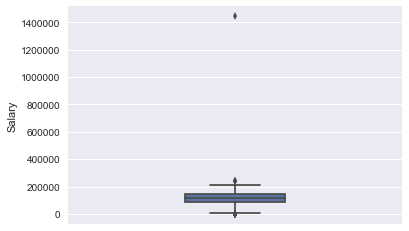

In [359]:
# Plot boxplot
sns.boxplot(data=df, y='Salary', width=0.3)

(2875, 13)


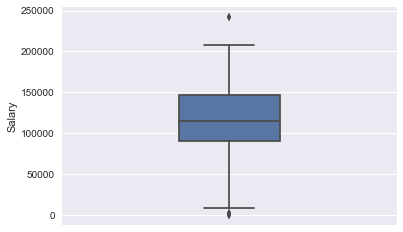

In [883]:
# find outlier
df[df['Salary']>1400000]

#remove outlier
df = df.drop(labels=1939)

#Print shape and plot new boxplot
print(df.shape)
sns.boxplot(data=df, y='Salary', width=0.3)

# Q1: Factors that Impact Salary
* As we are primarily interested in those with a salary for this question, we will leave out the rest of the data.

In [888]:
# Print shape of targeted dataframe without null salary values
print(df[df['Salary'].notnull()].shape)

#Generate new table with only filled salary values and print shape & head
salaryOnly = df[df['Salary'].notnull()].reset_index(drop=True)
print(salaryOnly.shape)
salaryOnly.head()

(618, 13)
(618, 13)


,Job_ID,Job_URL,Title,Type,City,Suburb,Industry,Hiring_Ent,Summary,Post_Date,job_Desc,job_Salary,Salary
0,34375173,https://www.seek.com.au/job/34375173,"Data Analyst - R, Python, AWS",Contract/Temp,Melbourne,NaN,Information & Communication Technology,FourQuarters Recruitment,Data Analyst required to deliver actionable in...,2017-09-11T06:00:57Z,Data Analyst required to develop and deliver a...,$800pd,180000.0
1,34358139,https://www.seek.com.au/job/34358139,Senior IT Data Analyst,Contract/Temp,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Finite IT Recruitment Solutions,Finite is looking for a Senior IT Data Analyst...,2017-09-08T03:40:18Z,Finite is looking for a Senior IT Data Analys...,AUD 600 - 800 ( based on the right experience ),157500.0
2,34362889,https://www.seek.com.au/job/34362889,Data Analyst - Pricing focused - build and ana...,Full Time,Melbourne,Bayside & South Eastern Suburbs,Information & Communication Technology,Valmont Industries ANZ,Love data and analysis? Newly created role for...,2017-09-08T07:01:07Z,Are you a data Geek? Do you love data and the ...,$70 - $80k + Super,75000.0
3,34402692,https://www.seek.com.au/job/34402692,Microsoft SQL BI Data Analyst,Full Time,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Genesis IT&T P/L,Microsoft SQL BI Data Analyst - Market leading...,2017-09-14T01:15:47Z,I'm seeking a highly driven Microsoft SQL BI D...,"Salary up to $115,000",115000.0
4,34395425,https://www.seek.com.au/job/34395425,Data Analyst | SE Suburbs| $95-105k+ Super,Full Time,Melbourne,Bayside & South Eastern Suburbs,Information & Communication Technology,Robert Half Technology,A family owned and operated business is lookin...,2017-09-13T04:36:49Z,The CompanyThis is a family business that comp...,$95k - $105k p.a. + Super,100000.0


### Insight: Salary by job type

Type
Contract/Temp    131360.855735
Full Time        104696.186953
Part Time        100000.000000
Name: Salary, dtype: float64


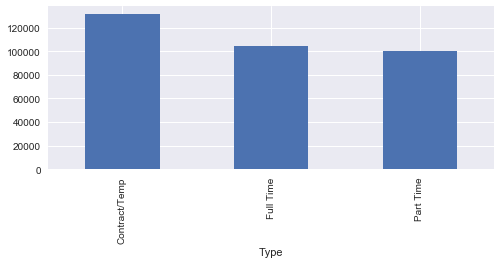

In [889]:
print(salaryOnly.groupby('Type')['Salary'].mean())
salaryOnly.groupby('Type')['Salary'].mean().plot(kind='bar', figsize=(8,3))

### Insight: Salary by job type

City
ACT                                    120028.326087
Adelaide                                95986.000000
Albany & Great Southern                241875.000000
Bairnsdale & Gippsland                 241875.000000
Brisbane                               106278.654545
Bundaberg & Wide Bay Burnett            70611.750000
Darwin                                  72499.500000
Geelong & Great Ocean Road              52499.500000
Geraldton, Gascoyne & Midwest          190000.000000
Gold Coast                              92000.000000
Gosford & Central Coast                104625.000000
Hobart                                  85405.750000
Lismore & Far North Coast               74511.000000
Melbourne                              109234.692500
Newcastle, Maitland & Hunter            99000.000000
Perth                                  103594.119048
Shepparton & Goulburn Valley            76248.130000
Sydney                                 121875.712139
Wollongong, Illawarra & South Coast     8

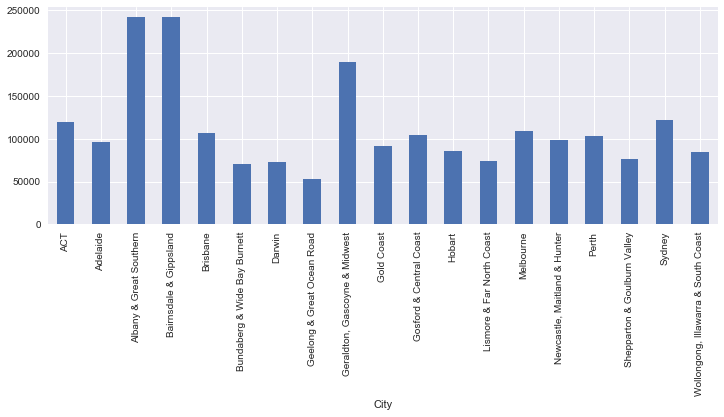

In [890]:
print(salaryOnly.groupby('City')['Salary'].mean())
salaryOnly.groupby('City')['Salary'].mean().plot(kind='bar', figsize=(12,4))

### Insight: Salary by city/suburb

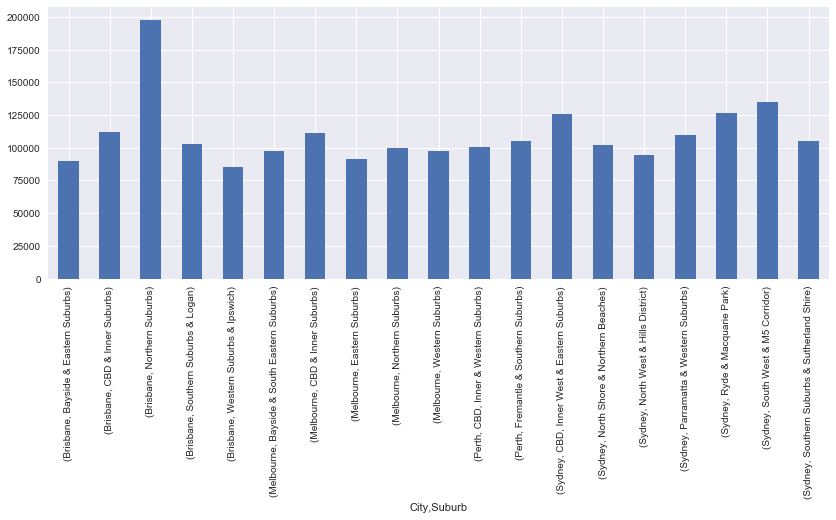

In [891]:
salaryOnly.groupby('Suburb')['Salary'].mean()
pd.pivot_table(salaryOnly, index=['City', 'Suburb']).drop(labels='Job_ID', axis=1).plot(kind='bar', figsize=(14,5), legend=False)

### Insight: Salary by industry type

Industry
Accounting                                 95399.186747
Administration & Office Support           135000.000000
Banking & Financial Services              127050.343750
CEO & General Management                  109999.500000
Call Centre & Customer Service             70000.000000
Consulting & Strategy                     115838.696429
Design & Architecture                     105000.000000
Education & Training                       79118.125000
Government & Defence                      113704.782857
Healthcare & Medical                       80000.000000
Human Resources & Recruitment              55795.437500
Information & Communication Technology    121415.037957
Insurance & Superannuation                105166.666667
Manufacturing, Transport & Logistics      116624.625000
Marketing & Communications                103250.000000
Mining, Resources & Energy                190000.000000
Real Estate & Property                     77500.000000
Sales                                  

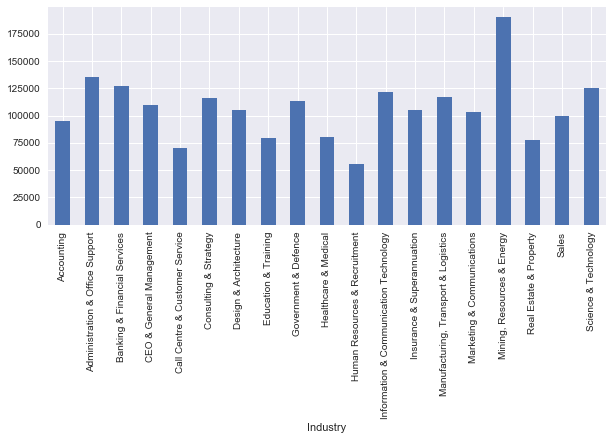

In [892]:
print(salaryOnly.groupby('Industry')['Salary'].mean())
salaryOnly.groupby('Industry')['Salary'].mean().plot(kind='bar', figsize=(10,4))

# Using NLP on Job Description
A method of predicting the salary could potentially be through looking at the job description and interpreting the text using Natural Language Processing

Let's explore whether a viable model can be built using this process

In [1046]:
from sklearn.model_selection import train_test_split

# Instantitate target and predictors
target= salaryOnly['Salary']
X=salaryOnly['job_Desc']

# Split our target and feature variable into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=7)

In [1047]:
# Import stopwords from NLTK
from nltk.corpus import stopwords

#Instantiate stopwords
stopWords = stopwords.words('english')

# Declare badWords to append to stop words
badWords = ['00', '000', '00005gbb', '00005krh', '004', '005', '009','00pm', '01', '02','0209',
            '0233', '0265', '0280626173', '0280969413','0282512100', '0282512105', '0292581121',
            '0293508158', '03','032', '0399828478', '0403', '0404', '0411', '0414', '0416',
            '0421', '0431', '0437', '0458', '0481', '0487', '0499', '05', '052', '060', '07','072',
            '0732588437','08', '087', '089', '09','093788bp', '099', '10', '100','1000', '1006', '1007',
            '10073869rfc','100k', '100kresource', '101', '1012','102', '1021', '103', '103k','105', 
            '1053', '106', '107', '1071', '107595', '10am','10mexperience', '11', '110', '110000k', 
            '110k', '1114131210bp', '112', '1142', '115','116', '12', '120', '1202', '120k', '120kone',
            '120kreputable', '122', '124', '125k','128', '12m', '13', '130','1300', '130k', '132', '14',
            '140', '140k', '147', '14th', 'a4', 'a4 pages'
            '14thfor', '15','150', '150k', '155k', '15677', '16', '160k', '168', '17',
            '1735', '18','180', '1800', '18185', '1834', '18365', '18437', '18478',
            '18488', '18491', '18536','18561', u'18563', '18603', '18month', '192', '1990', '1997',
            '1999', '1billion', '1lod','1mb', '1st', '20', '200', '2000', '2000phone', '200170272',
            '200171086', '200171386', '20022strong','2005', '2006', '2007', '2008', '2009', '201', '2010',
            '2011', '2012', '2012dot','2013', '2013ms', '2013sql', '2014', '2014strong', '2015',
            '2016', '2016demonstrated', '2017', '2018','2018day', '2019', '204', '2070', '21', '2111', '215',
            '216', '217', '22','2232', '23', '24', '2453', '2462', '2471', '25', '250',
            '250k', '253','259', '25961', '25980', '25981', '2638', '2672important',
            '268', '26important', '27', '270','2846', '28th', '29', '290', '291', '2ic', '2lod', '2nd',
            '2remuneration', '2xm', '2xmtechnology', '2yrs', '30', '300', '3039', '3063', '30pm',
            '31', '3100', '3135','3138', '314', '3147', '317', '3171', '3183', '32', '3221',
            '323', '3231','3232', '3258', '3319', '3330', '3333','3339', '33395625', '3353',
            '34', '35', '350', '3500','35131', '35131location', '3535', '36', '365', '3661',
            '3671', '3716', '372', '3722', '3725', '3735', '3829','38requisition', u'39', u'3996', 
            u'3bn', u'3rd', u'3yrs', u'40', u'4000', u'4002', u'4004', u'400per', u'409', u'41', 
            u'4202',u'4221', u'4224', u'422hours', u'426', u'4260', u'4279', u'4441',u'45', u'4500',
            u'457', u'46326', u'46901', u'470', u'48', u'4836',u'486', u'4936', u'497628', u'4999', 
            u'4a', u'4b', u'4yrs', u'50',u'500', u'500304', u'500k', u'5011', u'5111', u'5118', u'5145',
            u'53', u'5305', u'546', u'547', u'550', u'551', u'5611', u'5628',u'5640', u'5644', u'589', 
            u'5917', u'597', u'59pm', u'59pmif',u'5mill', u'5pm', u'5yrs', u'60', u'600', u'6082b446',
            '61', u'6113', u'612', u'61282709757', u'6163', u'6214', u'6215',
            u'623', u'6230', u'6267', u'628', u'6285', u'6297', u'6299',
            u'6380', u'6381', u'6382', u'639', u'642', u'6421', u'6430', u'65',
            u'650', u'656per', u'6570', u'661339bplearn', u'668', u'6716',
            u'6724', u'673', u'6737', u'675', u'6799', u'68', u'6801', u'6805',
            u'6824', u'6945', u'699', u'6c', u'6csap', u'6mths', u'70', u'700',
            u'715', u'716', u'718', u'720', u'722', u'7301''7306', u'731', u'74',
            u'744', u'746', u'748', u'75', u'750',u'7500', u'7511', u'7555', u'7556',
            u'7568', u'7575', u'7577',u'765', u'7701', u'7869', u'79', u'7908', u'79794479bplearn',
            u'7yrs', u'80', u'800', u'8023', u'8032', u'8047', u'805', u'8071',
            u'8095', u'8123', u'8133', u'818', u'82', u'820', u'8202', u'8216',
            u'822', u'8226', u'8227', u'8234', u'8235', u'8243', u'8245',
            u'8246', u'82523120', u'8270', u'8274', u'8289', u'82893232',
            '8292', u'8296', u'82d', u'83005003', u'8315', u'8320', u'8324',
            u'8328', u'8330', u'83305003', u'8344', u'8346', u'8356', u'8404',
            u'842', u'8423', u'84231005', u'84231033', u'8491', u'85', u'850',
            u'8615', u'8629', u'86291015', u'8632', u'8637', u'8644', u'868',
            u'86804220', u'87348', u'8741', u'88', u'8815', u'8837', u'8986',
            u'8yrs', u'90', u'900', u'9003', u'9020', u'9032', u'9087', u'9088',
            u'90k', u'90kexceptional', u'90m0319832', u'91', u'9103',
            u'9122763jo', u'9131', '9147', u'92', u'9200', u'9216', u'9231', u'9235', u'9236',
            u'9238', u'9240', u'92466781', u'9248', u'9249', u'9259', u'926',
            u'9262', u'9270', u'929', u'93', u'9326', u'9338', u'935', u'9376',
            u'9469', u'9499', u'95', u'9500', u'95000k', u'9535', u'9548',
            u'955', u'95k', u'9607', u'9616', u'9641', u'965', u'9691', u'9722',
            u'9757', u'9775', u'9780', u'9782', u'98', u'9861', u'9900',
            u'9911', u'9929', u'9948', u'995', u'996', u'998',
            '99828462', u'99828478', u'9993', u'9997', u'9people', '7301', '7306', 
            u'_______________________________________________',
            u'____________________________________________________________',
            u'___________________________________________________________________']

# Add additional stop words
for w in badWords:
    stopWords.append(w)

## Instantiate NLP vectorizers

In [1048]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Instantiate Count Vectorizer with stopwords
CV = CountVectorizer(stop_words=stopWords, ngram_range=(1, 2))

# Instantiate TfidfVectorizer with stop words
TF = TfidfVectorizer(stop_words=stopWords, ngram_range=(1, 2))

In [1049]:
# Fit transform the training data and store: matrix
XtrainCVmatrix = CV.fit_transform(X_train, y_train)
XtrainTFmatrix = TF.fit_transform(X_train, y_train)

# Convert matrix to dataframe for viewing
TFtrainMatrixView = pd.DataFrame(data=XtrainTFmatrix.todense(), columns=CV.get_feature_names())

# Print head
TFtrainMatrixView.head()

,14thfor,14thfor information,aaron,aaron aaron,aaron digitalnative,aba,aba ba,abacus,abacus human,abap,...,zero,zero threshold,zone,zone contribute,zone couple,zone substation,zones,zones nbsp,ﬁnance,ﬁnance solution
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, let's apply our model above to our X_test data

In [1050]:
#Apply our vector (CV) to transform x_test: XtestMatrix
XtestCVMatrix = CV.transform(X_test)
XtestTFMatrix = TF.transform(X_test)

# Convert type matrix to dataframe for viewing
TFtestview = pd.DataFrame(data=XtestTFMatrix.todense(), columns=CV.get_feature_names())

#Print head
TFtestview.head()

,14thfor,14thfor information,aaron,aaron aaron,aaron digitalnative,aba,aba ba,abacus,abacus human,abap,...,zero,zero threshold,zone,zone contribute,zone couple,zone substation,zones,zones nbsp,ﬁnance,ﬁnance solution
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1051]:
# Testing our model 
from sklearn.linear_model import Ridge
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score 
from nltk.stem.snowball import SnowballStemmer

# Instantiating Ridge model
RidModel = Ridge()

#Fitting for CV matrix (commented out)
#Ridmodel.fit(XtrainCVMatrix, y_train)

# Fitting to TFidf matrix
RidModel.fit(XtrainTFmatrix, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

## Upon scoring both TFID and count vectorizer, TFID shows an improvement
* Moving forward, we should use TFID rather than count vectorizer

In [1052]:
# Scoring for CountVectorizer
#scores = cross_val_score(RidModel, XtestCVmatrix, y=y_test)

# Scoring for TFidfVectorizer
scores = cross_val_score(RidModel, XtestTFMatrix, y=y_test)

# Print scores
print('CV Scores:{}\nMean score:{}'.format(scores, scores.mean()))

CV Scores:[ 0.15471663  0.10886552  0.18589789]
Mean score:0.149826680075


## Attempt to improve model using stemmer
* Our model is not performing well, so we will attempt to stem the words within the description to see if it results in an increase of score

In [1053]:
from textblob import TextBlob, Word

# initialize stemmer
stemmer = SnowballStemmer('english')

### Build our stemming function

In [1054]:
def split_into_stems(text):
    """Accepts text (text) and returns a list of the stemmed words in lower case
    """
    text = unicode(text, 'utf-8').lower()
    words = TextBlob(text).words
    # Returns list of stemmed words
    return [stemmer.stem(word) for word in words]

## Our Stemmed model
* Let's refit our model using the stemmed data. We will use it as our analyzer within TfidfVectorizer declaration

In [1055]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer with stopwords
TF = TfidfVectorizer(stop_words=stopWords, ngram_range=(1, 2), analyzer=split_into_stems)


# Fit transform the training data and store: matrix
XtrainMatrix = TF.fit_transform(X_train, y_train)

In [1056]:
#Apply our vector (CV) to transform x_test: XtestMatrix
XtestMatrix = TF.transform(X_test)

In [1057]:
# Testing our model 
from sklearn.linear_model import Ridge
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score 
from nltk.stem.snowball import SnowballStemmer

# Declare a new Ridge model
RidModel = Ridge()

# Fit to our data
RidModel.fit(XtrainMatrix, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [1058]:
# Generate and print scores
stemScores = cross_val_score(RidModel, XtestMatrix, y=y_test)
print('Scores:{}\nMean score:{}'.format(stemScores, stemScores.mean()))

Scores:[ 0.15042107  0.09573037  0.16410273]
Mean score:0.136751389589


# Results
* Using a stemmer has resulted in a worst score overall, and a slightly worse mean score. By removing stems, we are able to improve the model
* We will proceed with our original Ridge Model without the stemmer
* We will attempt to improve our model by using grid search

In [1059]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate Count Vectorizer with stopwords
TF = TfidfVectorizer(stop_words=stopWords, ngram_range=(1, 2))


# Fit transform the training data and store: matrix
XtrainMatrix = TF.fit_transform(X_train, y_train)

In [1060]:
#Apply our vector (CV) to transform x_test: XtestMatrix
XtestMatrix = TF.transform(X_test)

In [1061]:
# Testing our model 
RidModel = Ridge()

# Fit to our data
RidModel.fit(XtrainMatrix, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [1062]:
# Print scores
Scores = cross_val_score(RidModel, XtestMatrix, y=y_test)
print('Scores:{}\nMean score:{}'.format(Scores, Scores.mean()))

Scores:[ 0.15434405  0.10819448  0.18584073]
Mean score:0.149459752462


# Improving the old model
* We will revert to the use of our previous Ridge model and use GridSearch to improve the score

In [765]:
from sklearn.model_selection import GridSearchCV

# Create params diction ary with test parameters for gridsearch
params = {'alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1, 1.1, 1.2, 1.5],
          'normalize': [False, True],   
}

# Instantiate gridsearch
gSearch = GridSearchCV(RidModel, param_grid=params, n_jobs=3)

In [766]:
# Fit to our data
gSearch.fit(XtrainMatrix, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'normalize': [False, True], 'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [767]:
# Output best parameters
gSearch.best_params_

{'alpha': 0.4, 'normalize': False}

## Test our gridsearch results

In [1063]:
# Testing our model 
RidModel = Ridge(alpha=0.4)

# Fit to our data
RidModel.fit(XtrainMatrix, y_train)

Ridge(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [1064]:
# Print scores
scores = cross_val_score(RidModel, XtestMatrix, y=y_test)
print('Scores:{}\nMean score:{}'.format(scores, scores.mean()))

Scores:[ 0.18572871  0.14686904  0.23767184]
Mean score:0.190089866085


# Try different models
* As our model is performing quite poorly, we will use different methods to generate a better model.
* We will attempt to use the Decision Tree Regressor and ElasticNetCV

In [1065]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNetCV

# Instantiate Decision Tree and Elastic Net models for testing
DTree = DecisionTreeRegressor()
ElNet = ElasticNetCV(l1_ratio=0.9, n_alphas=100, n_jobs=3, normalize=True)

## Decision Tree Model test
* This model provided us with awful results. Proceed to try another

In [1066]:
# Fit to our data
DTree.fit(XtrainMatrix, y_train)

# Print scores
scores = cross_val_score(DTree, XtestMatrix, y=y_test)
print('Scores:{}\nMean score:{}'.format(scores, scores.mean()))

Scores:[-1.15232536 -0.37285305 -0.22607205]
Mean score:-0.583750155071


## Elastic Net CV test
* Using our results from GridSearch, we are able to see that a model with similar performance to our Ridge Model is achievable with Elastic Net. However, performance is still best with Ridge

In [1067]:
# Fit to our data
ElNet.fit(XtrainMatrix, y_train)

# Print scores
scores = cross_val_score(ElNet, XtestMatrix, y=y_test)
print('Scores:{}\nMean score:{}'.format(scores, scores.mean()))

Scores:[ 0.16316971  0.17958764  0.08595712]
Mean score:0.142904824374


## Gridsearch to improve above model
* Below we perform a gridsearch for our ElasticNet model. Unfortunately, Ridge is still more effective

In [666]:
# Instantiate params dict for test parameters
params = {'l1_ratio': [0.1,0.3,0.5,0.7,0.9],
          'normalize': [False, True], 
          'eps': [0.001,0.01,0.1],
          'n_alphas': [50,80,100,120,150],
          'n_jobs': [3]
}

#Instantiate gridsearch
gSearch = GridSearchCV(ElNet, param_grid=params, n_jobs=3)

# Fit to our data
gSearch.fit(XtrainMatrix, y_train)

# Print best params
gSearch.best_params_

{'eps': 0.001,
 'l1_ratio': 0.9,
 'n_alphas': 100,
 'n_jobs': 3,
 'normalize': True}

# Attempt a different model using dummy variables
* It may be helpful to split dummy variables from our table for Title, Type, City, and Industry, as we have seen that the differences in these categories have shown to impact salary

In [1068]:
# Print shape and head of dataframe
print(salaryOnly.shape)
salaryOnly.head()

(618, 13)


,Job_ID,Job_URL,Title,Type,City,Suburb,Industry,Hiring_Ent,Summary,Post_Date,job_Desc,job_Salary,Salary
0,34375173,https://www.seek.com.au/job/34375173,"Data Analyst - R, Python, AWS",Contract/Temp,Melbourne,NaN,Information & Communication Technology,FourQuarters Recruitment,Data Analyst required to deliver actionable in...,2017-09-11T06:00:57Z,Data Analyst required to develop and deliver a...,$800pd,180000.0
1,34358139,https://www.seek.com.au/job/34358139,Senior IT Data Analyst,Contract/Temp,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Finite IT Recruitment Solutions,Finite is looking for a Senior IT Data Analyst...,2017-09-08T03:40:18Z,Finite is looking for a Senior IT Data Analys...,AUD 600 - 800 ( based on the right experience ),157500.0
2,34362889,https://www.seek.com.au/job/34362889,Data Analyst - Pricing focused - build and ana...,Full Time,Melbourne,Bayside & South Eastern Suburbs,Information & Communication Technology,Valmont Industries ANZ,Love data and analysis? Newly created role for...,2017-09-08T07:01:07Z,Are you a data Geek? Do you love data and the ...,$70 - $80k + Super,75000.0
3,34402692,https://www.seek.com.au/job/34402692,Microsoft SQL BI Data Analyst,Full Time,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Genesis IT&T P/L,Microsoft SQL BI Data Analyst - Market leading...,2017-09-14T01:15:47Z,I'm seeking a highly driven Microsoft SQL BI D...,"Salary up to $115,000",115000.0
4,34395425,https://www.seek.com.au/job/34395425,Data Analyst | SE Suburbs| $95-105k+ Super,Full Time,Melbourne,Bayside & South Eastern Suburbs,Information & Communication Technology,Robert Half Technology,A family owned and operated business is lookin...,2017-09-13T04:36:49Z,The CompanyThis is a family business that comp...,$95k - $105k p.a. + Super,100000.0


In [1069]:
# Generate dummies from industry, city, and type columns
IndDum = pd.get_dummies(salaryOnly['Industry'])
CitDum = pd.get_dummies(salaryOnly['City'])
TypDum = pd.get_dummies(salaryOnly['Type'])

#Create custom dummies from title column
senior = salaryOnly['Title'].apply(lambda x: 1 if 'senior' in x or 'Senior' in x else 0)
python = salaryOnly['Title'].apply(lambda x: 1 if 'Python' in x or 'python' in x else 0)
data = salaryOnly['Title'].apply(lambda x: 1 if 'Data' in x or 'data' in x else 0)
analyst = salaryOnly['Title'].apply(lambda x: 1 if 'Analyst' in x or 'analyst' in x else 0)
sql = salaryOnly['Title'].apply(lambda x: 1 if 'sql' in x or 'SQL' in x else 0)

# Combine custom dummies into single table
TitlDum = pd.DataFrame({'Title_Senior': senior, 'Title_Python': python, 'Title_data': data, 'Title_Analyst': analyst, 'Title_SQL': sql})

In [1071]:
# Print combined custom dummy table
TitlDum.head()

,Title_Analyst,Title_Python,Title_SQL,Title_Senior,Title_data
0,1,1,0,0,1
1,1,0,0,1,1
2,1,0,0,0,1
3,1,0,1,0,1
4,1,0,0,0,1


### Let's concatenate our dummy variables with our salaryOnly table

In [1072]:
#Print the shape of previous dataframes
print(TypDum.shape)
print(salaryOnly.shape)

#Concatenate dummy variables with salaryOnly
salaryWDummies = pd.concat([salaryOnly, TypDum, IndDum, CitDum, TitlDum], axis=1)
print(salaryWDummies.shape)

(618, 3)
(618, 13)
(618, 59)


In [1073]:
# Declare Features variable by subsetting salaryWDummies table
Features = salaryWDummies.iloc[:,10:]

# Declare target from Salary column
target = salaryWDummies['Salary']

# Drop salary and job salary columns
Features = Features.drop(labels=['Salary', 'job_Salary'], axis=1)

# print head
Features.head()

,job_Desc,Contract/Temp,Full Time,Part Time,Accounting,Administration & Office Support,Banking & Financial Services,CEO & General Management,Call Centre & Customer Service,Consulting & Strategy,...,"Newcastle, Maitland & Hunter",Perth,Shepparton & Goulburn Valley,Sydney,"Wollongong, Illawarra & South Coast",Title_Analyst,Title_Python,Title_SQL,Title_Senior,Title_data
0,Data Analyst required to develop and deliver a...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,Finite is looking for a Senior IT Data Analys...,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
2,Are you a data Geek? Do you love data and the ...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,I'm seeking a highly driven Microsoft SQL BI D...,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
4,The CompanyThis is a family business that comp...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [1074]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(Features, target, test_size=0.2, random_state=7)

#### Let's split job_Desc from our train and test data, to generate the word matrix

In [1075]:
# Assign train and test data job_Desc columns to respective word test and train variables
word_train = X_train['job_Desc']
word_test = X_test['job_Desc']

* We also are required to drop it from our train and test dummies for now
* We will re-attach it with the word matrix

In [1076]:
# Drop job_desc titles from train and test data
X_train = X_train.drop(labels='job_Desc', axis=1)
X_test = X_test.drop(labels='job_Desc', axis=1)

In [1077]:
# Fit transform train data to word matrix
trainWordMat = TF.fit_transform(word_train)

# Use previous fit transformed model to transform test data
testWordMat = TF.transform(word_test)

In [1078]:
#Create dataframe from train matrix and print shape
trainWordMat = pd.DataFrame(data=trainWordMat.todense(), columns=TF.get_feature_names())
print(trainWordMat.shape)

# concatenating word matrix with train data and print shape
wordX_train = pd.concat([trainWordMat, X_train.reset_index(drop=True)], axis=1)
print(wordX_train.shape)


(494, 59178)
(494, 59224)


,14thfor,14thfor information,aaron,aaron aaron,aaron digitalnative,aba,aba ba,abacus,abacus human,abap,...,zero,zero threshold,zone,zone contribute,zone couple,zone substation,zones,zones nbsp,ﬁnance,ﬁnance solution
489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1079]:
# #Create dataframe from test matrix and print shape
testWordMat = pd.DataFrame(data=testWordMat.todense(), columns=TF.get_feature_names())
print(testWordMat.shape)

# concatenating word matrix with train data and print shape
wordX_test = pd.concat([testWordMat, X_test.reset_index(drop=True)], axis=1)
print(wordX_test.shape)
wordX_test.tail()

(124, 59178)
(124, 59224)


,14thfor,14thfor information,aaron,aaron aaron,aaron digitalnative,aba,aba ba,abacus,abacus human,abap,...,"Newcastle, Maitland & Hunter",Perth,Shepparton & Goulburn Valley,Sydney,"Wollongong, Illawarra & South Coast",Title_Analyst,Title_Python,Title_SQL,Title_Senior,Title_data
119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,0,0,0


In [1080]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, ElasticNet

# Declaration of Ridge model
#Model2 = Ridge(alpha=0.5)

# Declaration of ElasticNet
Model2 = ElasticNet(alpha=0.1, l1_ratio=0.8, normalize=True)

# Fit model to our data
Model2.fit(wordX_train.as_matrix(), y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

# Success! Improvement achieved!
* We have successfully improved the score of our model to predict salary incrementally
* Success rate is now 21.33%

In [1081]:
# Print scores
scores = cross_val_score(Model2, wordX_test.as_matrix(), y=y_test)
print('Scores:{}\nMean score:{}'.format(scores, scores.mean()))

Scores:[ 0.17133854  0.20569083  0.26278393]
Mean score:0.213271098518


#### Gridsearch for model above

In [1033]:

#ElasticNet Params
params = {'alpha': [0.1,0.5,1.0,3,5,8,10,15,20,25],
          'normalize': [False, True],
          'l1_ratio': [0.2,0.5,0.7,0.8,1]
}

# Ridge params
# params = {'alpha': [0.1,0.5,1.0,3,5,8,10,15,20,25],
#           'normalize': [False, True] 
# }

gSearch = GridSearchCV(RidModel2, param_grid=params, n_jobs=3)

gSearch.fit(XtrainMatrix, y_train)

gSearch.best_params_

{'alpha': 0.1, 'l1_ratio': 0.8, 'normalize': True}

# Question 2: What features are best able to determine senior vs. junior positions?
* We will start with the complete dataframe, and use the same code to create dummies from the job_Com file (not the salaryOnly file used in the previous question)

In [1042]:
# Print shape and head of dataframe
print(df.shape)
df.head()

(2875, 13)


,Job_ID,Job_URL,Title,Type,City,Suburb,Industry,Hiring_Ent,Summary,Post_Date,job_Desc,job_Salary,Salary
0,34376436,https://www.seek.com.au/job/34376436,Data Analyst,Contract/Temp,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Robert Walters,Big 4 Bank looking to add a Data Analyst to th...,2017-09-11T07:08:29Z,This will be a 3 month contract with a possibi...,Super,NaN
1,34376394,https://www.seek.com.au/job/34376394,Data Analyst,Contract/Temp,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Robert Walters,Big 4 Bank looking to add a Data Analyst to th...,2017-09-11T07:05:53Z,This will be a 3 month contract with a possibi...,Attractive daily rate,NaN
2,34376246,https://www.seek.com.au/job/34376246,Market Data Analyst - Tier 1 Bank - Market Rat...,Contract/Temp,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Infopeople,Tier 1 Bank - Market Data Analyst - High Profi...,2017-09-11T07:00:54Z,&nbsp; Tier 1 Financial Bank is seeking an ...,Negotiable,NaN
3,34375173,https://www.seek.com.au/job/34375173,"Data Analyst - R, Python, AWS",Contract/Temp,Melbourne,NaN,Information & Communication Technology,FourQuarters Recruitment,Data Analyst required to deliver actionable in...,2017-09-11T06:00:57Z,Data Analyst required to develop and deliver a...,$800pd,180000.0
4,34373096,https://www.seek.com.au/job/34373096,Senior IT Business Analyst/Data Analyst,Contract/Temp,Sydney,"CBD, Inner West & Eastern Suburbs",Information & Communication Technology,Clicks IT Recruitment,URGENT! Hiring a Senior IT Business Analyst/Da...,2017-09-11T04:05:17Z,Looking for Senior IT Business Analyst/Data An...,NaN,NaN


In [1082]:
# Create dummies from industry, city, and type column
IndDum = pd.get_dummies(df['Industry'])
CitDum = pd.get_dummies(df['City'])
TypDum = pd.get_dummies(df['Type'])

#Create custom dummies from title column
senior = df['Title'].apply(lambda x: 1 if 'senior' in x or 'Senior' in x else 0)
python = df['Title'].apply(lambda x: 1 if 'Python' in x or 'python' in x else 0)
data = df['Title'].apply(lambda x: 1 if 'Data' in x or 'data' in x else 0)
analyst = df['Title'].apply(lambda x: 1 if 'Analyst' in x or 'analyst' in x else 0)
sql = df['Title'].apply(lambda x: 1 if 'sql' in x or 'SQL' in x else 0)

# Create column from custom dummies from title column
TitlDum = pd.DataFrame({'Title_Python': python, 'Title_data': data, 'Title_Analyst': analyst, 'Title_SQL': sql})

# Print created dataframe shape and head
print(TitlDum.shape)
TitlDum.head()

(2875, 4)


,Title_Analyst,Title_Python,Title_SQL,Title_data
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,1,0,1
4,1,0,0,1


## Initial declaration of X and target variables for this section

In [1194]:
# Declare Predictor and Target
X = pd.concat([TitlDum, IndDum, CitDum, TypDum], axis=1, copy=True)
target = senior

In [1195]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X,target, test_size=0.2, random_state=7)

## Declaration of 3 separate models to compare
* Only uncomment a single model declaration at a time

In [1144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier

# Declaration of Random Forest Classifier
#model= RandomForestClassifier(min_samples_leaf= 0.1, min_samples_split= 2, n_estimators= 5)

# Declaration of Decision Tree Classifier
#model=DecisionTreeClassifier(max_depth=1, min_samples_leaf=1, min_samples_split=2)

# Declaration of Ridge Classifier
model= RidgeClassifier(alpha=2, normalize=True)

# Fit to our data
model.fit(X_train, y_train)

RidgeClassifier(alpha=2, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=True, random_state=None, solver='auto',
        tol=0.001)

In [1145]:
# Print scores
scores = cross_val_score(model, X_test, y=y_test)
print('Scores:{}\nMean score:{}'.format(scores, scores.mean()))

Scores:[ 0.83333333  0.83333333  0.83769634]
Mean score:0.834787667248


In [1147]:
# Print model coefficients
model.coef_

array([[ 0.0551214 ,  0.01483847, -0.08019718, -0.02788119,  0.02127707,
        -0.11706122,  0.06863104,  0.21285347, -0.12185877, -0.11089454,
         0.0008749 , -0.11523547,  0.00728137, -0.10744702,  0.04492409,
        -0.12317663,  0.18877895, -0.12021523, -0.01947776,  0.04145643,
        -0.12227062, -0.09090834,  0.01830591,  0.14694345, -0.0036986 ,
         0.        , -0.11993005, -0.00467778, -0.07873189,  0.02328686,
        -0.1105892 ,  0.        , -0.12900573, -0.1105892 , -0.04442024,
        -0.12896832, -0.04565224, -0.13755342,  0.01425034, -0.17217046,
        -0.06438681, -0.12479624, -0.04577992,  0.        , -0.1105892 ,
         0.4946895 ,  0.00192987, -0.11668065, -0.07258259, -0.00679803,
        -0.13763326, -0.11668065,  0.        ,  0.04166148, -0.14605876,
        -0.11668065, -0.11096904, -0.11798175,  0.04590742,  0.01901536,
        -0.01783699, -0.12202175]])

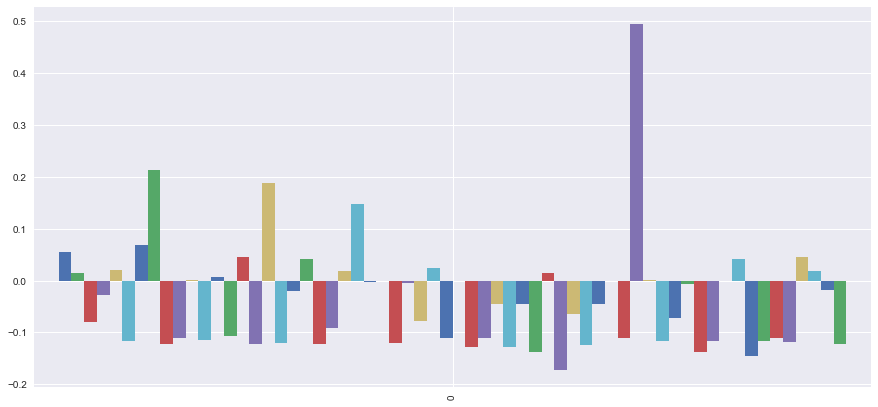

In [1172]:
# Place coefficients into dataframe
coefData = pd.DataFrame(columns=X_train.columns, data=model.coef_)

# Plot dataframe
coefData.plot(figsize=(15,7), kind='bar', legend=False, grid=True, width=8, sharex=True)

In [1180]:
# Sort coefficients by highest to lowest in table for viewing
coefData.T.sort_values(by=0, ascending=False).head(10)

,0
Mandurah & Peel,0.494689
CEO & General Management,0.212853
Hospitality & Tourism,0.188779
"Mining, Resources & Energy",0.146943
Banking & Financial Services,0.068631
Title_Analyst,0.055121
Casual/Vacation,0.045907
Government & Defence,0.044924
Sydney,0.041661
Insurance & Superannuation,0.041456


### According to the RandomForest Classifier: the features that are most probable to be present in senior positions is ( in order): 
Features that are most probable to be present in senior position ads:
1. Location: Melbourne
2. Full Time positions
3. Contract/Temp
4. Information & Communication Technology

### According to the Decision Tree Classifier:
* Heavily weights Analyst in the title for the model

### According to the Ridge Classifier:
* Heavily weights (49%) Mandurah & Peel(region of South West, Western Australia) listings
Followed by:
    1. CEO & General Management Industry ad label
    2. Hospitality & Tourism industry ad label
    3. Mining, Resources & Energy industry ad label

## Feature Selection
* Let's keep the features that have been deemed important by the three models and remove the rest

In [1196]:
# Columns to remove from features
colsToRemove = ['Title_Python', 'Title_SQL', 'Title_data',
       'Accounting', 'Administration & Office Support',
       'Banking & Financial Services',
       'Call Centre & Customer Service', 'Construction',
       'Consulting & Strategy', 'Design & Architecture',
       'Education & Training', 'Engineering', 'Government & Defence',
       'Healthcare & Medical', 
       'Human Resources & Recruitment',
       'Insurance & Superannuation', 'Legal',
       'Manufacturing, Transport & Logistics',
       'Marketing & Communications', 
       'Real Estate & Property', 'Retail & Consumer Products', 'Sales',
       'Science & Technology', 'ACT', 'Adelaide',
       'Albany & Great Southern', 'Bairnsdale & Gippsland',
       'Ballarat & Central Highlands',
       'Bendigo, Goldfields & Macedon Ranges', 'Brisbane',
       'Bundaberg & Wide Bay Burnett', 'Darwin', 'Dubbo & Central NSW',
       'Geelong & Great Ocean Road', 'Geraldton, Gascoyne & Midwest',
       'Gold Coast', 'Gosford & Central Coast', 'Hobart',
       'Kalgoorlie, Goldfields & Esperance', 'Lismore & Far North Coast',
        'Mornington Peninsula & Bass Coast',
       'Newcastle, Maitland & Hunter', 'Perth',
       'Port Macquarie & Mid North Coast', 'Shepparton & Goulburn Valley',
       'Sunshine Coast', 'Sydney', 'Tamworth & North West NSW',
       'Toowoomba & Darling Downs', 'Townsville & Northern QLD',
       'Wollongong, Illawarra & South Coast', 'Casual/Vacation',
        'Part Time']

# Generate new train and test data with less features
Optimal_X_train = X_train.drop(labels=colsToRemove, axis=1)
Optimal_X_test = X_test.drop(labels=colsToRemove, axis=1)

#### Used the Gridsearch below to improve above models
* Gridsearch successfully improved all of the models above, providing a slight increase in performance
* All models perform with a mean score over 80%

In [1110]:

#RandomForest Params
# params = {'n_estimators': [5,8,10,12,15],
#           'min_samples_split': [2,3,4,5,6,7,8],
#           'min_samples_leaf': [0.1,0.2,0.3,0.4,0.5],
# }

# Decision Tree params
# params = {'min_samples_split': [2,3,4,5,6,7,8],
#           'min_samples_leaf': [1,2,3,4,5],
#           'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8]
# }

# Ridge Classifier params
params = {'alpha': [0.5,1,2,3,4],
          'normalize': [False, True]
}

# Instantiate gridsearch
gSearch = GridSearchCV(model, param_grid=params, n_jobs=3)

# Fit to data
gSearch.fit(X_train, y_train)

# Print best parameters
gSearch.best_params_

{'alpha': 2, 'normalize': True}

## Testing our final model

In [1202]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier

# Instantiate Random Forest Classifier
#model= RandomForestClassifier(min_samples_leaf= 0.1, min_samples_split= 2, n_estimators= 5)

# Instantiate Decision Tree Classifier
#model=DecisionTreeClassifier(max_depth=1, min_samples_leaf=1, min_samples_split=2)

# Instantiate Ridge Classifier
model= RidgeClassifier(alpha=2, normalize=True)

# Fit to our data
model.fit(Optimal_X_train, y_train)

RidgeClassifier(alpha=2, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=True, random_state=None, solver='auto',
        tol=0.001)

In [1203]:
# Print scores
scores = cross_val_score(model, Optimal_X_test, y=y_test)
print('Scores:{}\nMean score:{}'.format(scores, scores.mean()))

Scores:[ 0.83333333  0.83333333  0.83769634]
Mean score:0.834787667248


# Results
* Feature selection resulted in no better or worse a model. 
* By including the high coefficients/weightings of all 3 models, we have maintained the exact same score (83.48%) with less features